In [1]:
# Imports and Setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional
import warnings
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO, SAC, TD3, DDPG
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
import torch
from collections import defaultdict
import os

# Add Optuna for hyperparameter tuning
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
import os, json, time

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")
print("All libraries imported successfully")


All libraries imported successfully


c:\Users\ryhan\anaconda3\envs\ML\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Sleep Optimization Environment

class SleepOptimizationEnv(gym.Env):
    """
    Gymnasium environment for sleep optimization based on NHANES data.
    State: [sleep_duration, cos_bedtime, sin_bedtime, cos_waketime, sin_waketime]
    Action: [delta_duration, delta_bedtime, delta_waketime] (continuous, bounded)
    Reward: Fat loss optimization with safety constraints
    """

    def __init__(self, reward_type="additive", max_steps=50, safety_strict=True):
        super().__init__()
        self.reward_type = reward_type  # 'additive' or 'multiplicative'
        self.max_steps = max_steps
        self.safety_strict = safety_strict
        self.current_step = 0

        # Action space: [delta_duration, delta_bedtime, delta_waketime]
        # Each delta is bounded to prevent unsafe changes
        self.action_space = spaces.Box(
            low=np.array([-0.5, -0.5, -0.5]),  # Max 30min changes per step
            high=np.array([0.5, 0.5, 0.5]),
            dtype=np.float32,
        )

        # State space: [duration, cos_bed, sin_bed, cos_wake, sin_wake]
        self.observation_space = spaces.Box(
            low=np.array([4.0, -1.0, -1.0, -1.0, -1.0]),
            high=np.array([12.0, 1.0, 1.0, 1.0, 1.0]),
            dtype=np.float32,
        )

        # Statistics for tracking
        self.episode_rewards = []
        self.reward_components = []

    def _time_to_circadian(self, time_hours):
        """Convert time in hours to circadian encoding (cos, sin)"""

        angle = 2 * np.pi * (time_hours / 24.0)
        
        return np.cos(angle), np.sin(angle)

    def _circadian_to_time(self, cos_val, sin_val):
        """Convert circadian encoding back to time in hours"""

        angle = np.arctan2(sin_val, cos_val)
        if angle < 0:
            angle += 2 * np.pi
        
        return (angle / (2 * np.pi)) * 24.0

    def _compute_fat_loss_reward(self, duration, bedtime, waketime):
        """
        Compute fat loss reward based on sleep science literature.
        Optimal around 7-8 hours with penalties for extremes.
        """

        # Duration component (peak around 7.5 hours)
        optimal_duration = 7.5
        duration_reward = 5.0 * np.exp(
            -0.5 * ((duration - optimal_duration) / 1.5) ** 2
        )

        # Circadian alignment (prefer bedtime 21:00-23:00, wake 06:00-08:00)
        bedtime_reward = 0
        if 21.0 <= bedtime <= 23.5:
            bedtime_reward = 2.0
        elif 20.0 <= bedtime < 21.0 or 23.5 < bedtime <= 24.5:
            bedtime_reward = 1.0

        waketime_reward = 0
        if 6.0 <= waketime <= 8.0:
            waketime_reward = 2.0
        elif 5.5 <= waketime < 6.0 or 8.0 < waketime <= 8.5:
            waketime_reward = 1.0

        return duration_reward + bedtime_reward + waketime_reward

    def _compute_sleep_health_reward(self, duration, bedtime, waketime):
        """Reward for maintaining healthy sleep patterns"""

        health_reward = 0

        # Consistency bonus (simplified - in real env would track history)
        health_reward += 1.0

        # Duration in healthy range
        if 6.5 <= duration <= 9.0:
            health_reward += 3.0
        elif 6.0 <= duration <= 10.0:
            health_reward += 1.5

        # Sleep efficiency proxy
        if 7.0 <= duration <= 8.5:
            health_reward += 1.0

        return health_reward

    def _compute_safety_penalty(self, duration, bedtime, waketime):
        """Penalty for unsafe sleep patterns"""

        penalty = 0

        # Hard safety constraints
        if duration < 4.0 or duration > 12.0:
            penalty += 20.0  # Severe penalty
        elif duration < 5.0 or duration > 10.0:
            penalty += 5.0  # Moderate penalty
        elif duration < 6.0 or duration > 9.5:
            penalty += 1.0  # Mild penalty

        # Extreme timing penalties
        if 4.0 <= bedtime <= 18.0:  # Daytime sleep
            penalty += 10.0

        # Very late bedtimes
        if bedtime > 2.0 and bedtime < 4.0:
            penalty += 3.0

        return penalty

    def _calculate_reward(self, duration, bedtime, waketime):
        """Calculate reward using specified reward function type"""

        R_fat = self._compute_fat_loss_reward(duration, bedtime, waketime)
        R_sleep = self._compute_sleep_health_reward(duration, bedtime, waketime)
        R_penalty = self._compute_safety_penalty(duration, bedtime, waketime)

        if self.reward_type == "additive":
            reward = R_fat + R_sleep - R_penalty
        elif self.reward_type == "multiplicative":
            # Ensure positive components for multiplication
            R_fat_pos = max(0.1, R_fat)
            R_sleep_pos = max(0.1, R_sleep)
            penalty_factor = max(0.1, 1 - R_penalty / 20.0)
            reward = R_fat_pos * (1 + R_sleep_pos / 10.0) * penalty_factor
        else:
            raise ValueError(f"Unknown reward type: {self.reward_type}")

        return reward, R_fat, R_sleep, R_penalty

    def reset(self, seed=None, options=None):
        """Reset environment to initial state"""

        if seed is not None:
            np.random.seed(seed)

        self.current_step = 0

        # Sample initial state from realistic NHANES-based distribution
        # Initial sleep duration (normal around 7.7 hours)

        self.duration = np.random.normal(7.7, 1.2)
        self.duration = np.clip(self.duration, 4.0, 12.0)

        # Initial bedtime (normal around 22:30)
        self.bedtime = np.random.normal(22.5, 1.2) % 24

        # Initial waketime based on duration
        self.waketime = (self.bedtime + self.duration) % 24

        # Convert to state representation
        cos_bed, sin_bed = self._time_to_circadian(self.bedtime)
        cos_wake, sin_wake = self._time_to_circadian(self.waketime)

        self.state = np.array(
            [self.duration, cos_bed, sin_bed, cos_wake, sin_wake], dtype=np.float32
        )

        return self.state, {}

    def step(self, action):
        """Execute one step in the environment"""

        self.current_step += 1

        # Apply action (deltas) to current state
        delta_duration, delta_bedtime, delta_waketime = action

        # Update sleep parameters with small noise for realism
        noise_scale = 0.05
        new_duration = np.clip(
            self.duration + delta_duration + np.random.normal(0, noise_scale), 4.0, 12.0
        )
        new_bedtime = (
            self.bedtime + delta_bedtime + np.random.normal(0, noise_scale)
        ) % 24

        # Ensure consistency (wake = bed + duration, with small flexibility)
        new_waketime = (new_bedtime + new_duration) % 24

        # Update state
        self.duration = new_duration
        self.bedtime = new_bedtime
        self.waketime = new_waketime

        # Convert to state representation
        cos_bed, sin_bed = self._time_to_circadian(self.bedtime)
        cos_wake, sin_wake = self._time_to_circadian(self.waketime)
        self.state = np.array(
            [self.duration, cos_bed, sin_bed, cos_wake, sin_wake], dtype=np.float32
        )

        # Calculate reward
        reward, R_fat, R_sleep, R_penalty = self._calculate_reward(
            self.duration, self.bedtime, self.waketime
        )

        # Check if episode is done
        terminated = self.current_step >= self.max_steps
        truncated = False

        # Add reward components to info
        info = {
            "R_fat": R_fat,
            "R_sleep": R_sleep,
            "R_penalty": R_penalty,
            "duration": self.duration,
            "bedtime": self.bedtime,
            "waketime": self.waketime,
            "safety_violation": R_penalty > 0,
            "total_reward": reward,
        }

        return self.state, reward, terminated, truncated, info

# Test the environment
print("Testing SleepOptimizationEnv...")

# Test both reward types
for reward_type in ["additive", "multiplicative"]:
    env = SleepOptimizationEnv(reward_type=reward_type)
    state, info = env.reset(seed=42)
    print(f"\n{reward_type.upper()} Environment:")
    print(f"Initial state shape: {state.shape}")
    print(f"Action space: {env.action_space}")

    # Test a few steps
    total_reward = 0
    for i in range(3):
        action = env.action_space.sample()
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        print(f"Step {i + 1}: reward={reward:.3f}, duration={info['duration']:.2f}h")

    print(f"Total reward over 3 steps: {total_reward:.3f}")

print("\nEnvironment testing completed successfully!")


Testing SleepOptimizationEnv...

ADDITIVE Environment:
Initial state shape: (5,)
Action space: Box(-0.5, 0.5, (3,), float32)
Step 1: reward=11.596, duration=8.72h
Step 2: reward=11.126, duration=8.95h
Step 3: reward=11.150, duration=8.94h
Total reward over 3 steps: 33.872

MULTIPLICATIVE Environment:
Initial state shape: (5,)
Action space: Box(-0.5, 0.5, (3,), float32)
Step 1: reward=13.168, duration=7.95h
Step 2: reward=12.750, duration=8.19h
Step 3: reward=11.088, duration=8.55h
Total reward over 3 steps: 37.006

Environment testing completed successfully!


In [3]:
# Training Configuration and Utilities

class MetricsCallback(BaseCallback):
    """Fixed callback to track training metrics"""

    def __init__(self, eval_env, eval_freq=1000, n_eval_episodes=10, verbose=0):
        super().__init__(verbose)
        self.eval_env = eval_env
        self.eval_freq = eval_freq
        self.n_eval_episodes = n_eval_episodes
        self.episode_lengths = []
        self.cumulative_steps = []
        self._steps_so_far = 0

        # Metrics storage
        self.episode_rewards = []
        self.episode_lengths = []
        self.eval_rewards = []
        self.eval_steps = []
        self.safety_violations = []
        self.reward_components = {"fat": [], "sleep": [], "penalty": []}

    def _on_step(self) -> bool:
        # Collect episode data - fixed indexing

        if "dones" in self.locals and "infos" in self.locals:
            dones = self.locals["dones"]
            infos = self.locals["infos"]

            # Handle vec envs: iterate per-env
            for done, info in zip(np.atleast_1d(dones), list(np.atleast_1d(infos))):
                if bool(done) and isinstance(info, dict) and ("episode" in info):
                    ep_len = int(info["episode"]["l"])
                    self.episode_lengths.append(ep_len)
                    self._steps_so_far += ep_len
                    self.cumulative_steps.append(self._steps_so_far)
                    self.episode_rewards.append(info["episode"]["r"])

        # Periodic evaluation - ensure it triggers

        if self.eval_freq > 0 and (self.num_timesteps % self.eval_freq == 0):
            mean_reward, std_reward = evaluate_policy(
                self.model,
                self.eval_env,
                n_eval_episodes=self.n_eval_episodes,
                deterministic=True,
                return_episode_rewards=False,
            )

            self.eval_rewards.append(mean_reward)

            self.eval_steps.append(self.num_timesteps)

            if self.verbose > 0:
                print(
                    f"Eval at step {self.num_timesteps}: {mean_reward:.2f} +/- {std_reward:.2f}"
                )

        return True


def create_model_with_params(algorithm, env, params=None, seed=42):
    """Create RL model with specified hyperparameters"""

    common_params = {
        "policy": "MlpPolicy",
        "env": env,
        "verbose": 0,
        "seed": seed,
        "device": "cuda" if torch.cuda.is_available() else "cpu",
    }

    # Default parameters if none provided
    if params is None:
        params = {}

    if algorithm == "PPO":
        return PPO(
            learning_rate=params.get("learning_rate", 0.0003),
            n_steps=params.get("n_steps", 2048),
            batch_size=params.get("batch_size", 64),
            n_epochs=params.get("n_epochs", 10),
            gamma=params.get("gamma", 0.99),
            gae_lambda=params.get("gae_lambda", 0.95),
            clip_range=params.get("clip_range", 0.2),
            **common_params,
        )

    elif algorithm == "SAC":
        return SAC(
            learning_rate=params.get("learning_rate", 0.0003),
            buffer_size=params.get("buffer_size", 1000000),
            learning_starts=params.get("learning_starts", 100),
            batch_size=params.get("batch_size", 256),
            tau=params.get("tau", 0.005),
            gamma=params.get("gamma", 0.99),
            **common_params,
        )

    elif algorithm == "TD3":
        return TD3(
            learning_rate=params.get("learning_rate", 0.001),
            buffer_size=params.get("buffer_size", 1000000),
            learning_starts=params.get("learning_starts", 100),
            batch_size=params.get("batch_size", 256),
            tau=params.get("tau", 0.005),
            gamma=params.get("gamma", 0.99),
            **common_params,
        )

    elif algorithm == "DDPG":
        return DDPG(
            learning_rate=params.get("learning_rate", 0.001),
            buffer_size=params.get("buffer_size", 1000000),
            learning_starts=params.get("learning_starts", 100),
            batch_size=params.get("batch_size", 256),
            tau=params.get("tau", 0.005),
            gamma=params.get("gamma", 0.99),
            **common_params,
        )

    else:
        raise ValueError(f"Unknown algorithm: {algorithm}")


# Legacy create_model function for backward compatibility
def create_model(algorithm, env, seed=42):
    """Create RL model with default parameters"""
    return create_model_with_params(algorithm, env, None, seed)


def evaluate_untrained_model(model, env, n_episodes=20):
    rewards = []
    for _ in range(n_episodes):
        obs, _ = env.reset()
        episode_reward, terminated, truncated = 0.0, False, False
        while not (terminated or truncated):
            action, _ = model.predict(obs, deterministic=False)  # untrained policy behavior
            obs, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
        rewards.append(episode_reward)
    return np.array(rewards)

print("Training utilities defined")


Training utilities defined


In [4]:
# Hyperparameter Optimization with Optuna

def suggest_hyperparameters(trial, algorithm):
    """Suggest hyperparameters for each algorithm using Optuna"""

    if algorithm == "PPO":
        return {
            "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True),
            "n_steps": trial.suggest_categorical("n_steps", [512, 1024, 2048, 4096]),
            "batch_size": trial.suggest_categorical("batch_size", [32, 64, 128, 256]),
            "n_epochs": trial.suggest_int("n_epochs", 3, 30),
            "gamma": trial.suggest_float("gamma", 0.9, 0.9999),
            "gae_lambda": trial.suggest_float("gae_lambda", 0.8, 1.0),
            "clip_range": trial.suggest_float("clip_range", 0.1, 0.4),
        }
    elif algorithm == "SAC":
        return {
            "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True),
            "buffer_size": trial.suggest_categorical("buffer_size", [50000, 100000, 200000]),
            "batch_size": trial.suggest_categorical("batch_size", [64, 128, 256, 512]),
            "gamma": trial.suggest_float("gamma", 0.9, 0.9999),
            "tau": trial.suggest_float("tau", 0.001, 0.02),
            "learning_starts": trial.suggest_categorical("learning_starts", [100, 500, 1000, 2000]),
        }
    elif algorithm == "TD3":
        return {
            "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True),
            "buffer_size": trial.suggest_categorical("buffer_size", [50000, 100000, 200000]),
            "batch_size": trial.suggest_categorical("batch_size", [64, 128, 256, 512]),
            "gamma": trial.suggest_float("gamma", 0.9, 0.9999),
            "tau": trial.suggest_float("tau", 0.001, 0.02),
            "learning_starts": trial.suggest_categorical("learning_starts", [100, 500, 1000, 2000]),
        }
    elif algorithm == "DDPG":
        return {
            "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True),
            "buffer_size": trial.suggest_categorical("buffer_size", [50000, 100000, 200000]),
            "batch_size": trial.suggest_categorical("batch_size", [64, 128, 256, 512]),
            "gamma": trial.suggest_float("gamma", 0.9, 0.9999),
            "tau": trial.suggest_float("tau", 0.001, 0.02),
            "learning_starts": trial.suggest_categorical("learning_starts", [100, 500, 1000, 2000]),
        }
    else:
        raise ValueError(f"Unknown algorithm: {algorithm}")


def optimize_hyperparameters(
    algorithm, reward_type, n_trials=20, training_timesteps=2000
):
    """Optimize hyperparameters using Optuna"""

    def objective(trial):
        # Get suggested hyperparameters
        params = suggest_hyperparameters(trial, algorithm)

        # Create environment and model
        train_env = Monitor(SleepOptimizationEnv(reward_type=reward_type))
        eval_env = SleepOptimizationEnv(reward_type=reward_type)

        try:
            model = create_model_with_params(algorithm, train_env, params)

            # Train model with reduced timesteps for optimization speed
            eval_freq = max(100, training_timesteps // 10)
            callback = MetricsCallback(eval_env, eval_freq=eval_freq, n_eval_episodes=5)
            model.learn(total_timesteps=training_timesteps, callback=callback)

            # Evaluate final performance
            mean_reward, _ = evaluate_policy(
                model, eval_env, n_eval_episodes=10, deterministic=True
            )
            return mean_reward

        except Exception as e:
            print(f"Trial failed with error: {e}")
            return -np.inf

    # Create study
    study = optuna.create_study(
        direction="maximize",
        sampler=TPESampler(seed=42),
        pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=training_timesteps // 4),
    )

    # Optimize
    print(f"Optimizing {algorithm} with {reward_type} reward...")
    study.optimize(objective, n_trials=n_trials, timeout=None)

    print(f"Best trial: {study.best_trial.number}")
    print(f"Best value: {study.best_value:.2f}")
    print(f"Best params: {study.best_trial.params}")

    return study.best_trial.params, study.best_value


print("Hyperparameter optimization functions defined")


Hyperparameter optimization functions defined


In [5]:
# Updated Training Function with Hyperparameter Tuning

def train_and_evaluate_models(
    total_timesteps=20000, eval_episodes=20, optimize_hp=True, n_trials=15
):
    """Train and evaluate all models with both reward types, including hyperparameter optimization"""

    algorithms = ["PPO", "SAC", "TD3", "DDPG"]
    reward_types = ["additive", "multiplicative"]

    # Storage for results
    results = {
        "before_training": {},
        "after_training": {},
        "training_metrics": {},
        "fine_tuned": {},  # Now contains hyperparameter-optimized results
        "best_hyperparameters": {},  # Store the best hyperparameters found
    }

    for reward_type in reward_types:
        results["before_training"][reward_type] = {}
        results["after_training"][reward_type] = {}
        results["training_metrics"][reward_type] = {}
        results["fine_tuned"][reward_type] = {}
        results["best_hyperparameters"][reward_type] = {}

        print(f"\n{'=' * 50}")
        print(f"Training with {reward_type.upper()} reward function")
        print(f"{'=' * 50}")

        for algorithm in algorithms:
            print(f"\nTraining {algorithm}...")

            # Create environments
            train_env = Monitor(SleepOptimizationEnv(reward_type=reward_type))
            eval_env = SleepOptimizationEnv(reward_type=reward_type)

            # Create model with default parameters
            model = create_model(algorithm, train_env)

            # Evaluate before training
            print("Evaluating before training...")

            before_rewards = evaluate_untrained_model(model, eval_env, eval_episodes)
            results["before_training"][reward_type][algorithm] = before_rewards

            # Setup callback for training metrics
            eval_freq = max(100, total_timesteps // 10)
            callback = MetricsCallback(
                eval_env, eval_freq=eval_freq, n_eval_episodes=10
            )

            # Train model with default parameters
            print(f"Training for {total_timesteps} timesteps...")
            model.learn(
                total_timesteps=total_timesteps, callback=callback, progress_bar=False
            )

            # Evaluate after training
            print("Evaluating after training...")
            after_rewards, _ = evaluate_policy(
                model,
                eval_env,
                n_eval_episodes=eval_episodes,
                deterministic=True,
                return_episode_rewards=True,
            )
            results["after_training"][reward_type][algorithm] = after_rewards

            # Store training metrics
            results["training_metrics"][reward_type][algorithm] = {
                "episode_rewards": callback.episode_rewards,
                "episode_lengths": callback.episode_lengths,
                "cumulative_steps": callback.cumulative_steps,
                "eval_rewards": callback.eval_rewards,
                "eval_steps": callback.eval_steps,
            }

            # Hyperparameter optimization (replaces fine-tuning)
            if optimize_hp:
                print("Optimizing hyperparameters...")

                # Optimize hyperparameters
                best_params, best_score = optimize_hyperparameters(
                    algorithm,
                    reward_type,
                    n_trials=n_trials,
                    training_timesteps=total_timesteps,
                )

                # Store best hyperparameters
                results["best_hyperparameters"][reward_type][algorithm] = best_params

                # Train final model with best hyperparameters
                print("Training with optimized hyperparameters...")

                # Create new environment and model with best params
                final_train_env = Monitor(SleepOptimizationEnv(reward_type=reward_type))
                final_eval_env = SleepOptimizationEnv(reward_type=reward_type)
                optimized_model = create_model_with_params(
                    algorithm, final_train_env, best_params
                )

                # Train with optimized hyperparameters
                final_callback = MetricsCallback(
                    final_eval_env, eval_freq=eval_freq, n_eval_episodes=10
                )
                optimized_model.learn(
                    total_timesteps=total_timesteps,
                    callback=final_callback,
                    progress_bar=False,
                )

                # Evaluate optimized model
                optimized_rewards, _ = evaluate_policy(
                    optimized_model,
                    final_eval_env,
                    n_eval_episodes=eval_episodes,
                    deterministic=True,
                    return_episode_rewards=True,
                )

                # Store results (in 'fine_tuned' for compatibility with visualization functions)
                results["fine_tuned"][reward_type][algorithm] = {
                    "rewards": optimized_rewards,
                    "training_metrics": {
                        "episode_rewards": final_callback.episode_rewards,
                        "episode_lengths": final_callback.episode_lengths,
                        "cumulative_steps": final_callback.cumulative_steps,
                        "eval_rewards": final_callback.eval_rewards,
                        "eval_steps": final_callback.eval_steps,
                    },
                    "best_hyperparameters": best_params,
                }

                timestamp = time.strftime("%Y%m%d-%H%M%S")
                save_root = os.path.join("models", reward_type)
                os.makedirs(save_root, exist_ok=True)

                # Filenames per algo and reward type
                model_path = os.path.join(save_root, f"{algorithm}_optimized_{timestamp}.zip")
                params_path = os.path.join(save_root, f"{algorithm}_best_params_{timestamp}.json")
                replay_path = os.path.join(save_root, f"{algorithm}_optimized_replay_buffer_{timestamp}.pkl")

                # 1) Save tuned model
                optimized_model.save(model_path)  # Contains weights + algorithm data [1]

                # 2) Save replay buffer for off-policy (SAC/TD3/DDPG); PPO has no replay buffer
                if hasattr(optimized_model, "save_replay_buffer"):
                    optimized_model.save_replay_buffer(replay_path)  # Pickle file [6]

                # 3) Save best hyperparameters
                with open(params_path, "w") as f:
                    json.dump(best_params, f, indent=2)

                # Optionally also save the default-trained model for comparison
                default_model_path = os.path.join(save_root, f"{algorithm}_default_{timestamp}.zip")
                model.save(default_model_path)  # The earlier, non-optimized model [1]

                # Keep paths in results for reporting
                results.setdefault("saved_models", {}).setdefault(reward_type, {})[algorithm] = {
                    "optimized_model": model_path,
                    "optimized_replay_buffer": replay_path if hasattr(optimized_model, "save_replay_buffer") else None,
                    "optimized_params": params_path,
                    "default_model": default_model_path
                }


                print(f"{algorithm} completed")
                print(
                    f"  Before: {np.mean(before_rewards):.2f} ± {np.std(before_rewards):.2f}"
                )
                print(
                    f"  After (default): {np.mean(after_rewards):.2f} ± {np.std(after_rewards):.2f}"
                )
                print(
                    f"  Optimized: {np.mean(optimized_rewards):.2f} ± {np.std(optimized_rewards):.2f}"
                )
                print(f"  Best params: {best_params}")

            else:
                # If not optimizing, just copy after_training results to fine_tuned for compatibility
                results["fine_tuned"][reward_type][algorithm] = {
                    "rewards": after_rewards,
                    "training_metrics": {
                        "episode_rewards": callback.episode_rewards,
                        "episode_lengths": callback.episode_lengths,
                        "cumulative_steps": callback.cumulative_steps,
                        "eval_rewards": callback.eval_rewards,
                        "eval_steps": callback.eval_steps,
                    },
                }

                print(f"{algorithm} completed")
                print(
                    f"  Before: {np.mean(before_rewards):.2f} ± {np.std(before_rewards):.2f}"
                )
                print(
                    f"  After: {np.mean(after_rewards):.2f} ± {np.std(after_rewards):.2f}"
                )

    return results


# Start training with hyperparameter optimization
print("Starting comprehensive training and hyperparameter optimization...")

results = train_and_evaluate_models(
    total_timesteps=10000,
    eval_episodes=10,
    optimize_hp=True,
    n_trials=10,  # Reduced for faster execution
)

print("\nAll training and optimization completed!")


Starting comprehensive training and hyperparameter optimization...

Training with ADDITIVE reward function

Training PPO...
Evaluating before training...
Training for 10000 timesteps...
Evaluating after training...


[I 2025-09-06 03:37:14,290] A new study created in memory with name: no-name-730053ba-45d1-4355-91bb-d8fe6a69c9ad


Optimizing hyperparameters...
Optimizing PPO with additive reward...


[I 2025-09-06 03:37:44,011] Trial 0 finished with value: 561.0661609172821 and parameters: {'learning_rate': 5.6115164153345e-05, 'n_steps': 512, 'batch_size': 128, 'n_epochs': 22, 'gamma': 0.9020563909801507, 'gae_lambda': 0.9939819704323989, 'clip_range': 0.34973279224012654}. Best is trial 0 with value: 561.0661609172821.
[I 2025-09-06 03:38:14,008] Trial 1 finished with value: 371.8582094401121 and parameters: {'learning_rate': 2.6587543983272695e-05, 'n_steps': 4096, 'batch_size': 128, 'n_epochs': 11, 'gamma': 0.9365995481450398, 'gae_lambda': 0.8912139968434072, 'clip_range': 0.33555278841790415}. Best is trial 0 with value: 561.0661609172821.
[I 2025-09-06 03:38:45,158] Trial 2 finished with value: 352.28672164082525 and parameters: {'learning_rate': 2.5081156860452307e-05, 'n_steps': 4096, 'batch_size': 256, 'n_epochs': 25, 'gamma': 0.9304309155404198, 'gae_lambda': 0.8195344228012769, 'clip_range': 0.3052699079536471}. Best is trial 0 with value: 561.0661609172821.
[I 2025-09-

Best trial: 3
Best value: 692.25
Best params: {'learning_rate': 7.591104805282687e-05, 'n_steps': 4096, 'batch_size': 64, 'n_epochs': 18, 'gamma': 0.9184669601070001, 'gae_lambda': 0.9939169255529117, 'clip_range': 0.3325398470083344}
Training with optimized hyperparameters...
PPO completed
  Before: 259.37 ± 149.22
  After (default): 689.70 ± 4.49
  Optimized: 676.13 ± 8.49
  Best params: {'learning_rate': 7.591104805282687e-05, 'n_steps': 4096, 'batch_size': 64, 'n_epochs': 18, 'gamma': 0.9184669601070001, 'gae_lambda': 0.9939169255529117, 'clip_range': 0.3325398470083344}

Training SAC...
Evaluating before training...
Training for 10000 timesteps...
Evaluating after training...


[I 2025-09-06 03:45:28,963] A new study created in memory with name: no-name-3708ceb5-1300-489b-89a9-7d1aee533797


Optimizing hyperparameters...
Optimizing SAC with additive reward...


[I 2025-09-06 03:47:50,340] Trial 0 finished with value: 694.322805571556 and parameters: {'learning_rate': 5.6115164153345e-05, 'buffer_size': 50000, 'batch_size': 512, 'gamma': 0.9600513896731466, 'tau': 0.014453378978124865, 'learning_starts': 500}. Best is trial 0 with value: 694.322805571556.
[I 2025-09-06 03:50:09,015] Trial 1 finished with value: 688.7769864559174 and parameters: {'learning_rate': 2.3102018878452926e-05, 'buffer_size': 200000, 'batch_size': 256, 'gamma': 0.9291852503886683, 'tau': 0.007960875022580142, 'learning_starts': 500}. Best is trial 0 with value: 694.322805571556.
[I 2025-09-06 03:52:34,178] Trial 2 finished with value: 691.6691451072693 and parameters: {'learning_rate': 0.00015304852121831474, 'buffer_size': 100000, 'batch_size': 256, 'gamma': 0.9304309155404198, 'tau': 0.0028557701661212935, 'learning_starts': 100}. Best is trial 0 with value: 694.322805571556.
[I 2025-09-06 03:54:56,718] Trial 3 finished with value: -2.8378530744463206 and parameters:

Best trial: 0
Best value: 694.32
Best params: {'learning_rate': 5.6115164153345e-05, 'buffer_size': 50000, 'batch_size': 512, 'gamma': 0.9600513896731466, 'tau': 0.014453378978124865, 'learning_starts': 500}
Training with optimized hyperparameters...
SAC completed
  Before: 413.86 ± 122.47
  After (default): 675.76 ± 6.85
  Optimized: 691.82 ± 5.31
  Best params: {'learning_rate': 5.6115164153345e-05, 'buffer_size': 50000, 'batch_size': 512, 'gamma': 0.9600513896731466, 'tau': 0.014453378978124865, 'learning_starts': 500}

Training TD3...
Evaluating before training...
Training for 10000 timesteps...
Evaluating after training...


[I 2025-09-06 04:11:28,151] A new study created in memory with name: no-name-0ef407dc-6cec-4bff-9bf4-e3d2ce3748e9


Optimizing hyperparameters...
Optimizing TD3 with additive reward...


[I 2025-09-06 04:12:39,546] Trial 0 finished with value: 676.5839311122894 and parameters: {'learning_rate': 5.6115164153345e-05, 'buffer_size': 50000, 'batch_size': 512, 'gamma': 0.9600513896731466, 'tau': 0.014453378978124865, 'learning_starts': 500}. Best is trial 0 with value: 676.5839311122894.
[I 2025-09-06 04:13:49,674] Trial 1 finished with value: 647.7594053030014 and parameters: {'learning_rate': 2.3102018878452926e-05, 'buffer_size': 200000, 'batch_size': 256, 'gamma': 0.9291852503886683, 'tau': 0.007960875022580142, 'learning_starts': 500}. Best is trial 0 with value: 676.5839311122894.
[I 2025-09-06 04:15:04,673] Trial 2 finished with value: 682.6396792411804 and parameters: {'learning_rate': 0.00015304852121831474, 'buffer_size': 100000, 'batch_size': 256, 'gamma': 0.9304309155404198, 'tau': 0.0028557701661212935, 'learning_starts': 100}. Best is trial 2 with value: 682.6396792411804.
[I 2025-09-06 04:16:19,117] Trial 3 finished with value: 534.5290531635285 and parameter

Best trial: 2
Best value: 682.64
Best params: {'learning_rate': 0.00015304852121831474, 'buffer_size': 100000, 'batch_size': 256, 'gamma': 0.9304309155404198, 'tau': 0.0028557701661212935, 'learning_starts': 100}
Training with optimized hyperparameters...
TD3 completed
  Before: -423.56 ± 55.18
  After (default): 685.92 ± 7.31
  Optimized: 689.50 ± 6.50
  Best params: {'learning_rate': 0.00015304852121831474, 'buffer_size': 100000, 'batch_size': 256, 'gamma': 0.9304309155404198, 'tau': 0.0028557701661212935, 'learning_starts': 100}

Training DDPG...
Evaluating before training...
Training for 10000 timesteps...
Evaluating after training...


[I 2025-09-06 04:25:30,351] A new study created in memory with name: no-name-1a5ce74a-6069-4c2d-bc2c-2fb0a0da7a58


Optimizing hyperparameters...
Optimizing DDPG with additive reward...


[I 2025-09-06 04:26:48,361] Trial 0 finished with value: 672.267741060257 and parameters: {'learning_rate': 5.6115164153345e-05, 'buffer_size': 50000, 'batch_size': 512, 'gamma': 0.9600513896731466, 'tau': 0.014453378978124865, 'learning_starts': 500}. Best is trial 0 with value: 672.267741060257.
[I 2025-09-06 04:28:07,418] Trial 1 finished with value: 601.5303605556488 and parameters: {'learning_rate': 2.3102018878452926e-05, 'buffer_size': 200000, 'batch_size': 256, 'gamma': 0.9291852503886683, 'tau': 0.007960875022580142, 'learning_starts': 500}. Best is trial 0 with value: 672.267741060257.
[I 2025-09-06 04:29:26,682] Trial 2 finished with value: 658.3812134742736 and parameters: {'learning_rate': 0.00015304852121831474, 'buffer_size': 100000, 'batch_size': 256, 'gamma': 0.9304309155404198, 'tau': 0.0028557701661212935, 'learning_starts': 100}. Best is trial 0 with value: 672.267741060257.
[I 2025-09-06 04:30:48,289] Trial 3 finished with value: -40.486170035600665 and parameters:

Best trial: 5
Best value: 687.97
Best params: {'learning_rate': 0.0003503398491158688, 'buffer_size': 200000, 'batch_size': 256, 'gamma': 0.9358107262815728, 'tau': 0.0032015121309774647, 'learning_starts': 100}
Training with optimized hyperparameters...
DDPG completed
  Before: -423.56 ± 55.18
  After (default): 481.60 ± 7.74
  Optimized: 651.34 ± 5.76
  Best params: {'learning_rate': 0.0003503398491158688, 'buffer_size': 200000, 'batch_size': 256, 'gamma': 0.9358107262815728, 'tau': 0.0032015121309774647, 'learning_starts': 100}

Training with MULTIPLICATIVE reward function

Training PPO...
Evaluating before training...
Training for 10000 timesteps...
Evaluating after training...


[I 2025-09-06 04:39:55,310] A new study created in memory with name: no-name-4a6f1cfd-99d4-4be8-afb6-fa799d28ff6d


Optimizing hyperparameters...
Optimizing PPO with multiplicative reward...


[I 2025-09-06 04:40:25,627] Trial 0 finished with value: 453.03998999595643 and parameters: {'learning_rate': 5.6115164153345e-05, 'n_steps': 512, 'batch_size': 128, 'n_epochs': 22, 'gamma': 0.9020563909801507, 'gae_lambda': 0.9939819704323989, 'clip_range': 0.34973279224012654}. Best is trial 0 with value: 453.03998999595643.
[I 2025-09-06 04:40:56,454] Trial 1 finished with value: 388.3179894685745 and parameters: {'learning_rate': 2.6587543983272695e-05, 'n_steps': 4096, 'batch_size': 128, 'n_epochs': 11, 'gamma': 0.9365995481450398, 'gae_lambda': 0.8912139968434072, 'clip_range': 0.33555278841790415}. Best is trial 0 with value: 453.03998999595643.
[I 2025-09-06 04:41:28,430] Trial 2 finished with value: 361.3977137088776 and parameters: {'learning_rate': 2.5081156860452307e-05, 'n_steps': 4096, 'batch_size': 256, 'n_epochs': 25, 'gamma': 0.9304309155404198, 'gae_lambda': 0.8195344228012769, 'clip_range': 0.3052699079536471}. Best is trial 0 with value: 453.03998999595643.
[I 2025-

Best trial: 4
Best value: 665.12
Best params: {'learning_rate': 0.0007568292060167617, 'n_steps': 2048, 'batch_size': 256, 'n_epochs': 10, 'gamma': 0.9827908771642777, 'gae_lambda': 0.8713506653387179, 'clip_range': 0.18428035290621425}
Training with optimized hyperparameters...
PPO completed
  Before: 270.45 ± 98.03
  After (default): 666.22 ± 5.06
  Optimized: 669.39 ± 2.55
  Best params: {'learning_rate': 0.0007568292060167617, 'n_steps': 2048, 'batch_size': 256, 'n_epochs': 10, 'gamma': 0.9827908771642777, 'gae_lambda': 0.8713506653387179, 'clip_range': 0.18428035290621425}

Training SAC...
Evaluating before training...
Training for 10000 timesteps...
Evaluating after training...


[I 2025-09-06 04:47:50,362] A new study created in memory with name: no-name-78e50fc5-a9ac-4618-a0cb-782b843208c9


Optimizing hyperparameters...
Optimizing SAC with multiplicative reward...


[I 2025-09-06 04:50:09,323] Trial 0 finished with value: 665.1640434265137 and parameters: {'learning_rate': 5.6115164153345e-05, 'buffer_size': 50000, 'batch_size': 512, 'gamma': 0.9600513896731466, 'tau': 0.014453378978124865, 'learning_starts': 500}. Best is trial 0 with value: 665.1640434265137.
[I 2025-09-06 04:52:27,835] Trial 1 finished with value: 639.5194006919861 and parameters: {'learning_rate': 2.3102018878452926e-05, 'buffer_size': 200000, 'batch_size': 256, 'gamma': 0.9291852503886683, 'tau': 0.007960875022580142, 'learning_starts': 500}. Best is trial 0 with value: 665.1640434265137.
[I 2025-09-06 04:54:50,391] Trial 2 finished with value: 666.0342944145202 and parameters: {'learning_rate': 0.00015304852121831474, 'buffer_size': 100000, 'batch_size': 256, 'gamma': 0.9304309155404198, 'tau': 0.0028557701661212935, 'learning_starts': 100}. Best is trial 2 with value: 666.0342944145202.
[I 2025-09-06 04:57:14,538] Trial 3 finished with value: 120.69894030094147 and paramete

Best trial: 2
Best value: 666.03
Best params: {'learning_rate': 0.00015304852121831474, 'buffer_size': 100000, 'batch_size': 256, 'gamma': 0.9304309155404198, 'tau': 0.0028557701661212935, 'learning_starts': 100}
Training with optimized hyperparameters...
SAC completed
  Before: 374.02 ± 76.30
  After (default): 660.82 ± 6.91
  Optimized: 665.36 ± 7.66
  Best params: {'learning_rate': 0.00015304852121831474, 'buffer_size': 100000, 'batch_size': 256, 'gamma': 0.9304309155404198, 'tau': 0.0028557701661212935, 'learning_starts': 100}

Training TD3...
Evaluating before training...
Training for 10000 timesteps...
Evaluating after training...


[I 2025-09-06 05:13:57,984] A new study created in memory with name: no-name-080043f0-ad78-4f95-bc67-28da92bf392d


Optimizing hyperparameters...
Optimizing TD3 with multiplicative reward...


[I 2025-09-06 05:15:09,555] Trial 0 finished with value: 126.59414218664169 and parameters: {'learning_rate': 5.6115164153345e-05, 'buffer_size': 50000, 'batch_size': 512, 'gamma': 0.9600513896731466, 'tau': 0.014453378978124865, 'learning_starts': 500}. Best is trial 0 with value: 126.59414218664169.
[I 2025-09-06 05:16:20,976] Trial 1 finished with value: 424.59914469718933 and parameters: {'learning_rate': 2.3102018878452926e-05, 'buffer_size': 200000, 'batch_size': 256, 'gamma': 0.9291852503886683, 'tau': 0.007960875022580142, 'learning_starts': 500}. Best is trial 1 with value: 424.59914469718933.
[I 2025-09-06 05:17:32,742] Trial 2 finished with value: 661.3935399532318 and parameters: {'learning_rate': 0.00015304852121831474, 'buffer_size': 100000, 'batch_size': 256, 'gamma': 0.9304309155404198, 'tau': 0.0028557701661212935, 'learning_starts': 100}. Best is trial 2 with value: 661.3935399532318.
[I 2025-09-06 05:18:48,108] Trial 3 finished with value: 178.53913703262805 and para

Best trial: 2
Best value: 661.39
Best params: {'learning_rate': 0.00015304852121831474, 'buffer_size': 100000, 'batch_size': 256, 'gamma': 0.9304309155404198, 'tau': 0.0028557701661212935, 'learning_starts': 100}
Training with optimized hyperparameters...
TD3 completed
  Before: 79.69 ± 26.35
  After (default): 630.16 ± 7.34
  Optimized: 601.72 ± 7.17
  Best params: {'learning_rate': 0.00015304852121831474, 'buffer_size': 100000, 'batch_size': 256, 'gamma': 0.9304309155404198, 'tau': 0.0028557701661212935, 'learning_starts': 100}

Training DDPG...
Evaluating before training...
Training for 10000 timesteps...
Evaluating after training...


[I 2025-09-06 05:28:03,508] A new study created in memory with name: no-name-2f39057d-f729-4a09-9c74-48859531c895


Optimizing hyperparameters...
Optimizing DDPG with multiplicative reward...


[I 2025-09-06 05:29:19,717] Trial 0 finished with value: 657.6658054828644 and parameters: {'learning_rate': 5.6115164153345e-05, 'buffer_size': 50000, 'batch_size': 512, 'gamma': 0.9600513896731466, 'tau': 0.014453378978124865, 'learning_starts': 500}. Best is trial 0 with value: 657.6658054828644.
[I 2025-09-06 05:30:37,639] Trial 1 finished with value: 662.9025682449341 and parameters: {'learning_rate': 2.3102018878452926e-05, 'buffer_size': 200000, 'batch_size': 256, 'gamma': 0.9291852503886683, 'tau': 0.007960875022580142, 'learning_starts': 500}. Best is trial 1 with value: 662.9025682449341.
[I 2025-09-06 05:31:59,084] Trial 2 finished with value: 417.79853119850156 and parameters: {'learning_rate': 0.00015304852121831474, 'buffer_size': 100000, 'batch_size': 256, 'gamma': 0.9304309155404198, 'tau': 0.0028557701661212935, 'learning_starts': 100}. Best is trial 1 with value: 662.9025682449341.
[I 2025-09-06 05:33:19,205] Trial 3 finished with value: 46.01526514478028 and paramete

Best trial: 1
Best value: 662.90
Best params: {'learning_rate': 2.3102018878452926e-05, 'buffer_size': 200000, 'batch_size': 256, 'gamma': 0.9291852503886683, 'tau': 0.007960875022580142, 'learning_starts': 500}
Training with optimized hyperparameters...
DDPG completed
  Before: 79.69 ± 26.35
  After (default): 99.18 ± 11.92
  Optimized: 661.70 ± 3.95
  Best params: {'learning_rate': 2.3102018878452926e-05, 'buffer_size': 200000, 'batch_size': 256, 'gamma': 0.9291852503886683, 'tau': 0.007960875022580142, 'learning_starts': 500}

All training and optimization completed!


In [6]:
# Visualization Functions

def plot_episode_rewards_before_training(results, save_plots=True):
    """Plot episode rewards before training for each model, with additive and multiplicative on the same subplot"""

    algorithms = ["PPO", "SAC", "TD3", "DDPG"]
    reward_types = ["additive", "multiplicative"]

    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    fig.suptitle(
        "Episode Rewards Before Training (Additive vs Multiplicative)",
        fontsize=16,
        fontweight="bold",
    )

    for j, algorithm in enumerate(algorithms):
        ax = axes[j]

        for reward_type, color, marker in zip(
            reward_types, ["tab:blue", "tab:orange"], ["o", "s"]
        ):
            rewards = results["before_training"][reward_type][algorithm]
            episodes = np.arange(1, len(rewards) + 1)

            # Trace for this reward type
            ax.plot(
                episodes,
                rewards,
                marker + "-",
                alpha=0.8,
                linewidth=2,
                color=color,
                label=reward_type.capitalize(),
            )

            # Mean line and annotation for this reward type
            mean_reward = np.mean(rewards)
            ax.axhline(mean_reward, color=color, linestyle="--", alpha=0.6)

            ax.text(
                0.02,
                0.95 if reward_type == "additive" else 0.85,
                f"{reward_type.capitalize()} Mean: {mean_reward:.2f}",
                transform=ax.transAxes,
                va="top",
                color=color,
                bbox=dict(
                    boxstyle="round", facecolor="white", alpha=0.7, edgecolor=color
                ),
            )

        ax.set_title(f"{algorithm}", fontweight="bold")
        ax.set_xlabel("Episode")

        if j == 0:
            ax.set_ylabel("Total Reward")

        ax.grid(True, alpha=0.3)
        ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    if save_plots:
        plt.savefig(
            "figs/episode_rewards_before_training_combined.png", dpi=300, bbox_inches="tight"
        )

    plt.show()


def plot_episode_rewards_before_after(results, save_plots=True):
    """Plot episode rewards before and after training, overlaying additive and multiplicative per model with aligned episodes"""

    algorithms = ["PPO", "SAC", "TD3", "DDPG"]

    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    fig.suptitle(
        "Episode Rewards Before and After Training (Aligned Episodes, Additive vs Multiplicative)",
        fontsize=16,
        fontweight="bold",
    )

    def plot_series(ax, x_index, y_arr, label, color, linestyle, marker):
        x = x_index[: len(y_arr)]

        ax.plot(
            x,
            y_arr,
            marker + linestyle,
            alpha=0.85,
            linewidth=2,
            color=color,
            label=label,
            markersize=4,
        )

    for j, algorithm in enumerate(algorithms):
        ax = axes[j]

        # Extract arrays
        add_before = np.array(results["before_training"]["additive"][algorithm])
        mul_before = np.array(results["before_training"]["multiplicative"][algorithm])
        add_after = np.array(results["after_training"]["additive"][algorithm])
        mul_after = np.array(results["after_training"]["multiplicative"][algorithm])

        # Aligned episode indices per phase (both start at 1)
        n_before = max(len(add_before), len(mul_before))
        n_after = max(len(add_after), len(mul_after))
        ep_before = np.arange(1, n_before + 1)
        ep_after = np.arange(1, n_after + 1)

        # Plot Before (solid) and After (dashed) for both reward types
        plot_series(
            ax, ep_before, add_before, "Additive - Before", "tab:blue", "-", "o"
        )
        plot_series(
            ax, ep_before, mul_before, "Multiplicative - Before", "tab:orange", "-", "s"
        )
        plot_series(ax, ep_after, add_after, "Additive - After", "tab:blue", "--", "o")
        plot_series(
            ax, ep_after, mul_after, "Multiplicative - After", "tab:orange", "--", "s"
        )

        # mean lines for After phase
        if len(add_after) > 0:
            ax.axhline(np.mean(add_after), color="tab:blue", linestyle=":", alpha=0.7)
        if len(mul_after) > 0:
            ax.axhline(np.mean(mul_after), color="tab:orange", linestyle=":", alpha=0.7)

        # Improvement annotations
        if len(add_before) > 0 and len(add_after) > 0:
            add_impr = np.mean(add_after) - np.mean(add_before)

            ax.text(
                0.02,
                0.98,
                f"Add Δ: {add_impr:+.2f}",
                transform=ax.transAxes,
                va="top",
                bbox=dict(
                    boxstyle="round", facecolor="white", alpha=0.8, edgecolor="tab:blue"
                ),
                color="tab:blue",
            )

        if len(mul_before) > 0 and len(mul_after) > 0:
            mul_impr = np.mean(mul_after) - np.mean(mul_before)
            ax.text(
                0.02,
                0.86,
                f"Mul Δ: {mul_impr:+.2f}",
                transform=ax.transAxes,
                va="top",
                bbox=dict(
                    boxstyle="round",
                    facecolor="white",
                    alpha=0.8,
                    edgecolor="tab:orange",
                ),
                color="tab:orange",
            )

        ax.set_title(f"{algorithm}", fontweight="bold")
        ax.set_xlabel("Episode (phase-aligned)")

        if j == 0:
            ax.set_ylabel("Total Reward")

        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=9)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    if save_plots:
        plt.savefig(
            "figs/episode_rewards_before_after_training_aligned.png",
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()


def plot_fine_tuned_vs_regular(results, save_plots=True):
    """Plot episode rewards for hyperparameter-optimized vs regular models"""

    algorithms = ["PPO", "SAC", "TD3", "DDPG"]

    reward_types = ["additive", "multiplicative"]

    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    fig.suptitle(
        "Hyperparameter-Optimized vs Default Models", fontsize=16, fontweight="bold"
    )

    for i, reward_type in enumerate(reward_types):
        for j, algorithm in enumerate(algorithms):
            ax = axes[i, j]

            regular_rewards = results["after_training"][reward_type][algorithm]

            optimized_rewards = results["fine_tuned"][reward_type][algorithm]["rewards"]

            episodes_regular = np.arange(1, len(regular_rewards) + 1)

            episodes_optimized = np.arange(1, len(optimized_rewards) + 1)

            ax.plot(
                episodes_regular,
                regular_rewards,
                "o-",
                alpha=0.7,
                label="Default Params",
                color="blue",
            )

            ax.plot(
                episodes_optimized,
                optimized_rewards,
                "s-",
                alpha=0.7,
                label="Optimized Params",
                color="green",
            )

            ax.set_title(f"{algorithm} ({reward_type.capitalize()})", fontweight="bold")

            ax.set_xlabel("Episode")

            ax.set_ylabel("Total Reward")

            ax.legend()

            ax.grid(True, alpha=0.3)

            # Add performance comparison

            regular_mean = np.mean(regular_rewards)

            optimized_mean = np.mean(optimized_rewards)

            improvement = optimized_mean - regular_mean

            ax.text(
                0.05,
                0.95,
                f"HP Improvement: {improvement:+.2f}",
                transform=ax.transAxes,
                verticalalignment="top",
                bbox=dict(boxstyle="round", facecolor="lightblue", alpha=0.8),
            )

    plt.tight_layout()

    if save_plots:
        plt.savefig(
            "figs/hyperparameter_optimized_vs_default_rewards.png",
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()


print("Visualization functions defined")


Visualization functions defined


In [7]:
# Training Metrics Visualization

def calculate_training_metrics(episode_rewards, eval_rewards=None, eval_steps=None):
    ep = np.asarray(episode_rewards, dtype=float)
    if ep.size == 0:
        return [], [], []
    
    # Windowing: at least 1 and at most len(ep)
    window = max(1, min(100, max(1, ep.size // 4)))
    mean_rewards, cv_values, learning_rates = [], [], []
    
    for i in range(window, ep.size + 1):
        w = ep[i - window:i]
        m = float(np.mean(w))
        s = float(np.std(w))
        
        mean_rewards.append(m)
        cv_values.append((s / abs(m)) if m != 0 else 0.0)
        
        if i >= 2 * window:
            prev_m = float(np.mean(ep[i - 2*window:i - window]))
            learning_rates.append(((m - prev_m) / window) if prev_m != 0 else 0.0)
        else:
            learning_rates.append(0.0)
            
    return mean_rewards, cv_values, learning_rates

def plot_training_metrics_non_fine_tuned(results, save_plots=True):
    """Plot training metrics for non-hyperparameter-optimized models using eval_steps as Training Steps"""
    
    algorithms = ['PPO', 'SAC', 'TD3', 'DDPG']
    reward_types = ['additive', 'multiplicative']
    metrics = ['mean_reward', 'cv', 'learning_rate']
    metric_names = ['Mean Reward', 'Coefficient of Variation', 'Learning Rate']
    
    for metric_idx, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        fig.suptitle(f'{metric_name} During Training (Default Parameters)',
                    fontsize=16, fontweight='bold')
        
        for i, reward_type in enumerate(reward_types):
            for j, algorithm in enumerate(algorithms):
                ax = axes[i, j]
                
                episode_rewards = results['training_metrics'][reward_type][algorithm]['episode_rewards']
                eval_rewards = results['training_metrics'][reward_type][algorithm]['eval_rewards']
                eval_steps = results['training_metrics'][reward_type][algorithm]['eval_steps']
                
                mean_rewards, cv_values, learning_rates = calculate_training_metrics(
                    episode_rewards, eval_rewards, eval_steps
                )
                
                if metric == 'mean_reward':
                    y_data = mean_rewards
                elif metric == 'cv':
                    y_data = cv_values
                else:  # learning_rate
                    y_data = learning_rates
                
                if len(y_data) > 0:
                    # Use eval_steps as x-axis for consistent training step representation
                    if len(eval_steps) > 0:
                        # If we have eval data, use eval_steps directly or interpolate
                        if len(eval_steps) >= len(y_data):
                            x_data = np.array(eval_steps[:len(y_data)])
                        else:
                            # Interpolate eval_steps to match y_data length
                            if len(eval_steps) > 1:
                                x_data = np.linspace(eval_steps[0], eval_steps[-1], len(y_data))
                            else:
                                x_data = np.linspace(0, eval_steps[0] if eval_steps else 1000, len(y_data))
                    else:
                        # Fallback: estimate steps based on episode count and typical episode length
                        max_episode_length = 50  # From environment max_steps
                        x_data = np.linspace(0, len(episode_rewards) * max_episode_length, len(y_data))
                    
                    ax.plot(x_data, y_data, '-', linewidth=2, alpha=0.8)
                    
                    # Add trend line
                    if len(y_data) > 10:
                        z = np.polyfit(x_data, y_data, 1)
                        p = np.poly1d(z)
                        ax.plot(x_data, p(x_data), '--', alpha=0.7, color='red')
                
                ax.set_title(f'{algorithm} ({reward_type.capitalize()})', fontweight='bold')
                ax.set_xlabel('Training Steps')
                ax.set_ylabel(metric_name)
                ax.grid(True, alpha=0.3)
                
                # Add final value
                if len(y_data) > 0:
                    final_value = y_data[-1]
                    ax.text(0.05, 0.95, f'Final: {final_value:.3f}',
                           transform=ax.transAxes, verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        if save_plots:
            plt.savefig(f'figs/{metric}_default_params.png', dpi=300, bbox_inches='tight')
        plt.show()

def plot_training_metrics_comparison(results, save_plots=True):
    """Plot training metrics comparing hyperparameter-optimized vs default models using eval_steps as Training Steps"""
    
    algorithms = ['PPO', 'SAC', 'TD3', 'DDPG']
    reward_types = ['additive', 'multiplicative']
    metrics = ['mean_reward', 'cv', 'learning_rate']
    metric_names = ['Mean Reward', 'Coefficient of Variation', 'Learning Rate']
    
    for metric_idx, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        fig.suptitle(f'{metric_name}: Hyperparameter-Optimized vs Default Parameters',
                    fontsize=16, fontweight='bold')
        
        for i, reward_type in enumerate(reward_types):
            for j, algorithm in enumerate(algorithms):
                ax = axes[i, j]
                
                # Default training metrics
                default_rewards = results['training_metrics'][reward_type][algorithm]['episode_rewards']
                default_eval_steps = results['training_metrics'][reward_type][algorithm]['eval_steps']
                def_mean, def_cv, def_conv = calculate_training_metrics(
                    default_rewards, [], []
                )
                
                # Optimized metrics
                opt_rewards = results['fine_tuned'][reward_type][algorithm]['training_metrics']['episode_rewards']
                opt_eval_steps = results['fine_tuned'][reward_type][algorithm]['training_metrics']['eval_steps']
                opt_mean, opt_cv, opt_conv = calculate_training_metrics(
                    opt_rewards, [], []
                )
                
                # Combine for visualization
                if metric == 'mean_reward':
                    def_data, opt_data = def_mean, opt_mean
                elif metric == 'cv':
                    def_data, opt_data = def_cv, opt_cv
                else:  # learning_rate
                    def_data, opt_data = def_conv, opt_conv
                
                # Plot default training using eval_steps
                if len(def_data) > 0:
                    if len(default_eval_steps) > 0:
                        if len(default_eval_steps) >= len(def_data):
                            x_def = np.array(default_eval_steps[:len(def_data)])
                        else:
                            # Interpolate eval_steps to match data length
                            if len(default_eval_steps) > 1:
                                x_def = np.linspace(default_eval_steps[0], default_eval_steps[-1], len(def_data))
                            else:
                                x_def = np.linspace(0, default_eval_steps[0] if default_eval_steps else 1000, len(def_data))
                    else:
                        # Fallback: estimate based on episode count
                        max_episode_length = 50
                        x_def = np.linspace(0, len(default_rewards) * max_episode_length, len(def_data))
                    
                    ax.plot(x_def, def_data, '-', linewidth=2, alpha=0.8,
                           label='Default', color='blue')
                
                # Plot optimized training using its own eval_steps
                if len(opt_data) > 0:
                    if len(opt_eval_steps) > 0:
                        if len(opt_eval_steps) >= len(opt_data):
                            x_opt = np.array(opt_eval_steps[:len(opt_data)])
                        else:
                            # Interpolate eval_steps to match data length
                            if len(opt_eval_steps) > 1:
                                x_opt = np.linspace(opt_eval_steps[0], opt_eval_steps[-1], len(opt_data))
                            else:
                                x_opt = np.linspace(0, opt_eval_steps[0] if opt_eval_steps else 1000, len(opt_data))
                    else:
                        # Fallback: estimate based on episode count  
                        max_episode_length = 50
                        x_opt = np.linspace(0, len(opt_rewards) * max_episode_length, len(opt_data))
                    
                    ax.plot(x_opt, opt_data, '-', linewidth=2, alpha=0.8,
                           label='Optimized', color='green')
                
                ax.set_title(f'{algorithm} ({reward_type.capitalize()})', fontweight='bold')
                ax.set_xlabel('Training Steps')
                ax.set_ylabel(metric_name)
                ax.legend()
                ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        if save_plots:
            plt.savefig(f'figs/{metric}_comparison_optimized.png', dpi=300, bbox_inches='tight')
        plt.show()

print("Training metrics visualization functions updated to use eval_steps for consistent Training Steps")

Training metrics visualization functions updated to use eval_steps for consistent Training Steps


Generating all required visualizations...
1. Generating episode rewards before training plots...


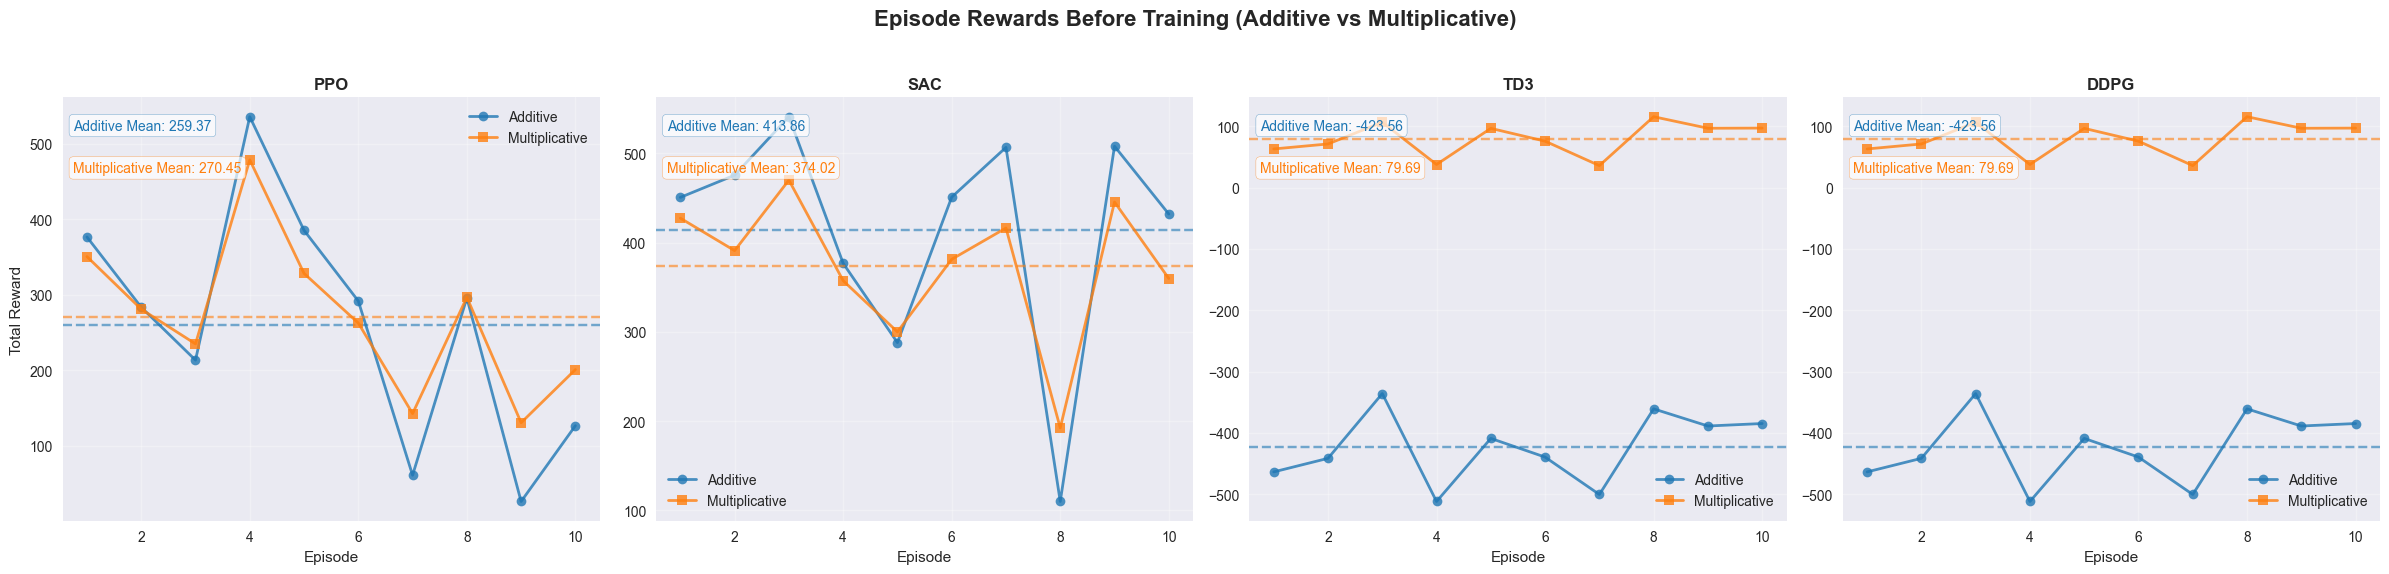

2. Generating before/after training comparison plots...


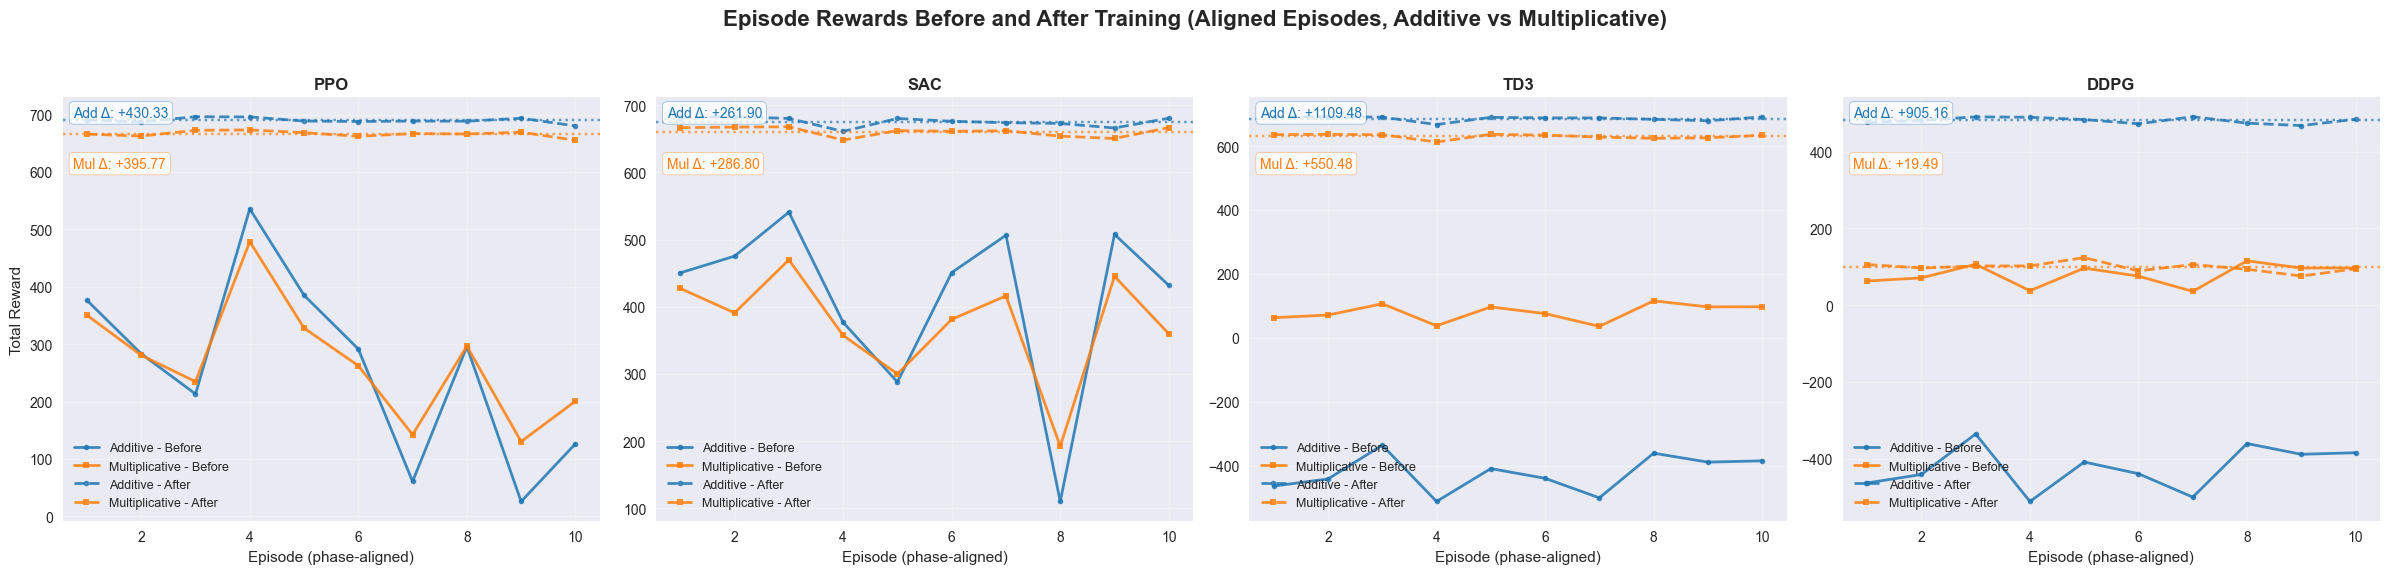

3. Generating hyperparameter-optimized vs default model plots...


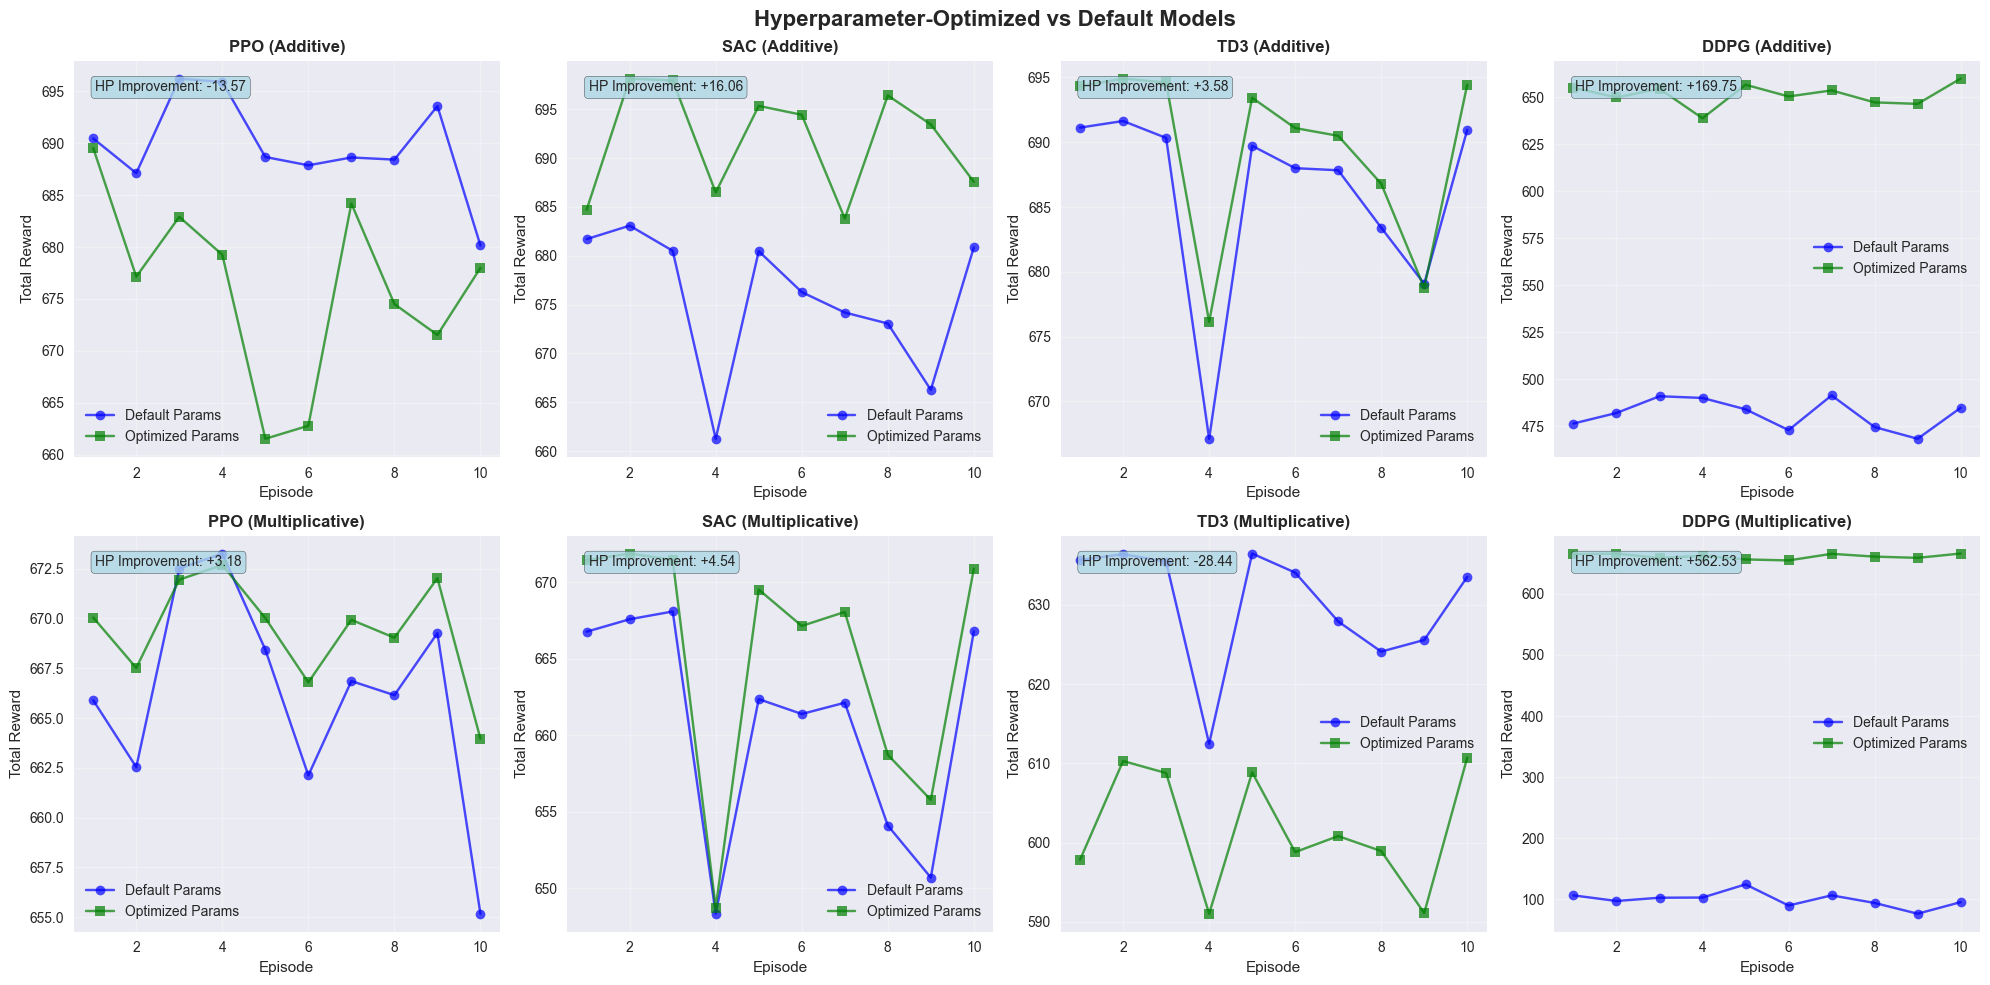

4. Generating training metrics plots for default models...


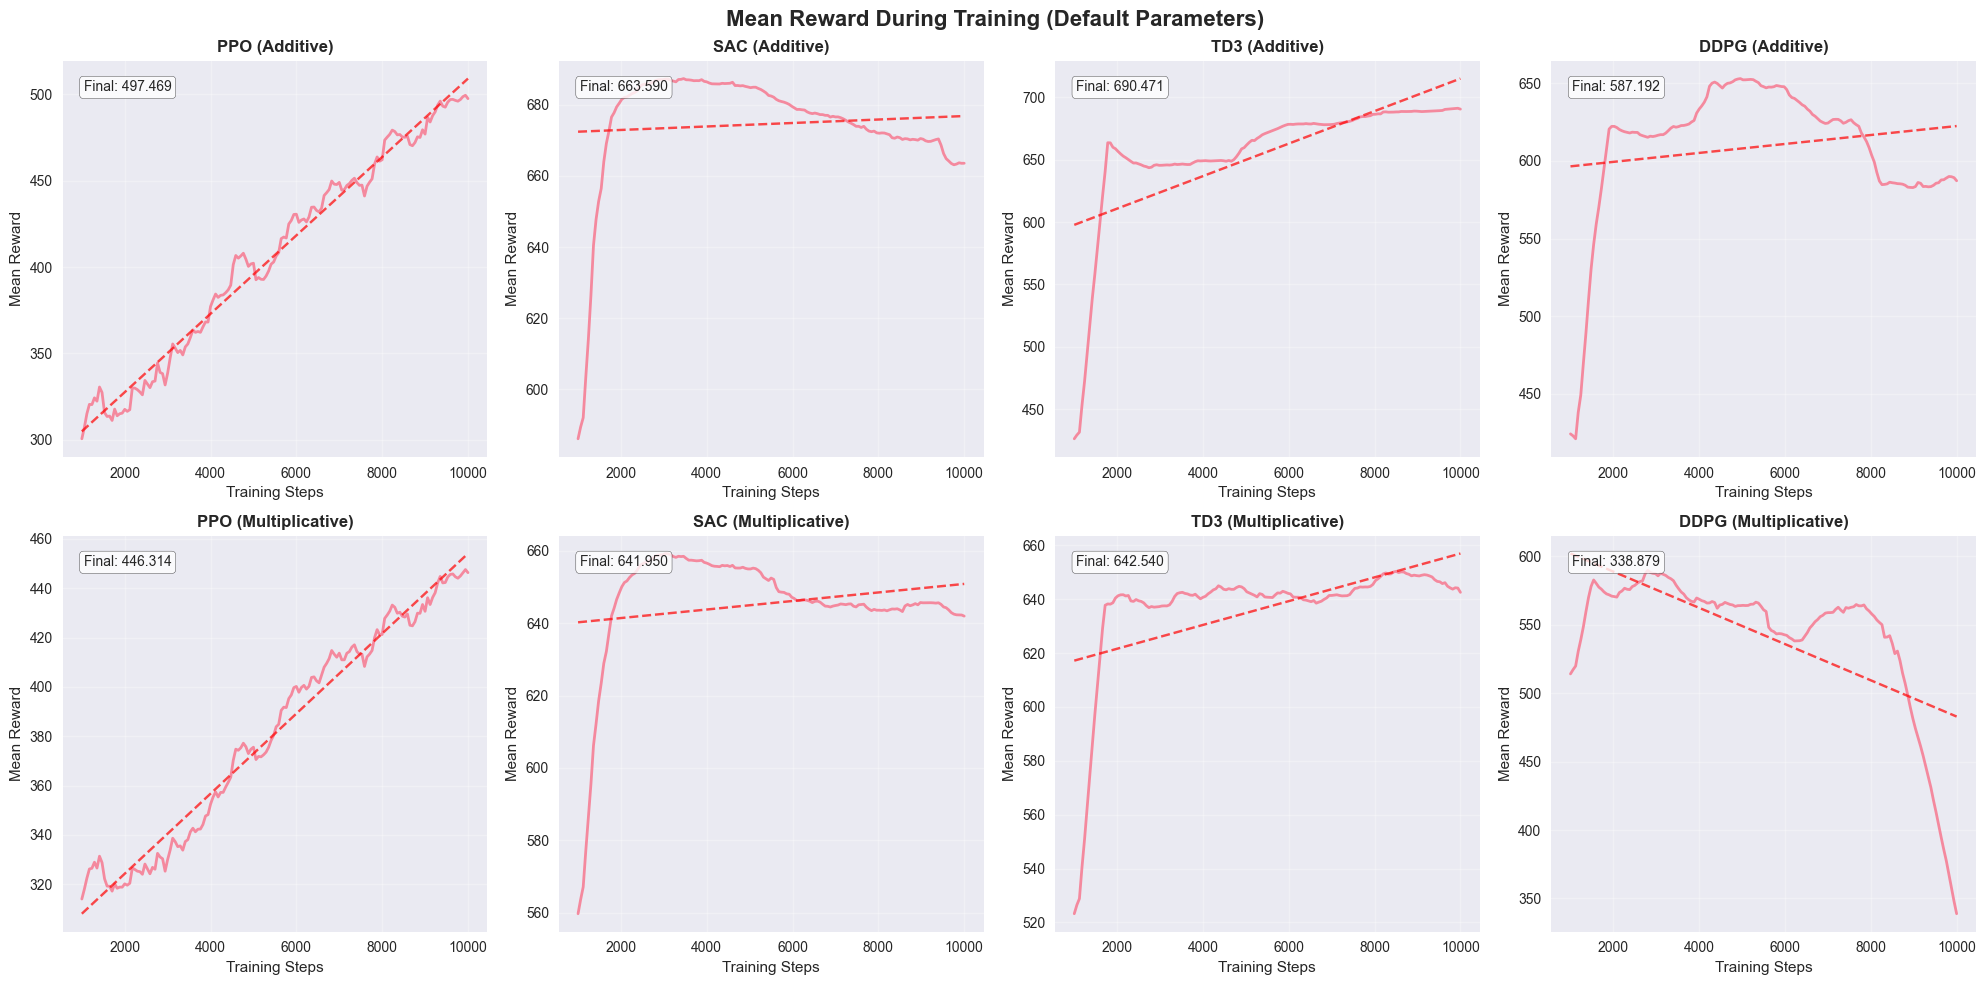

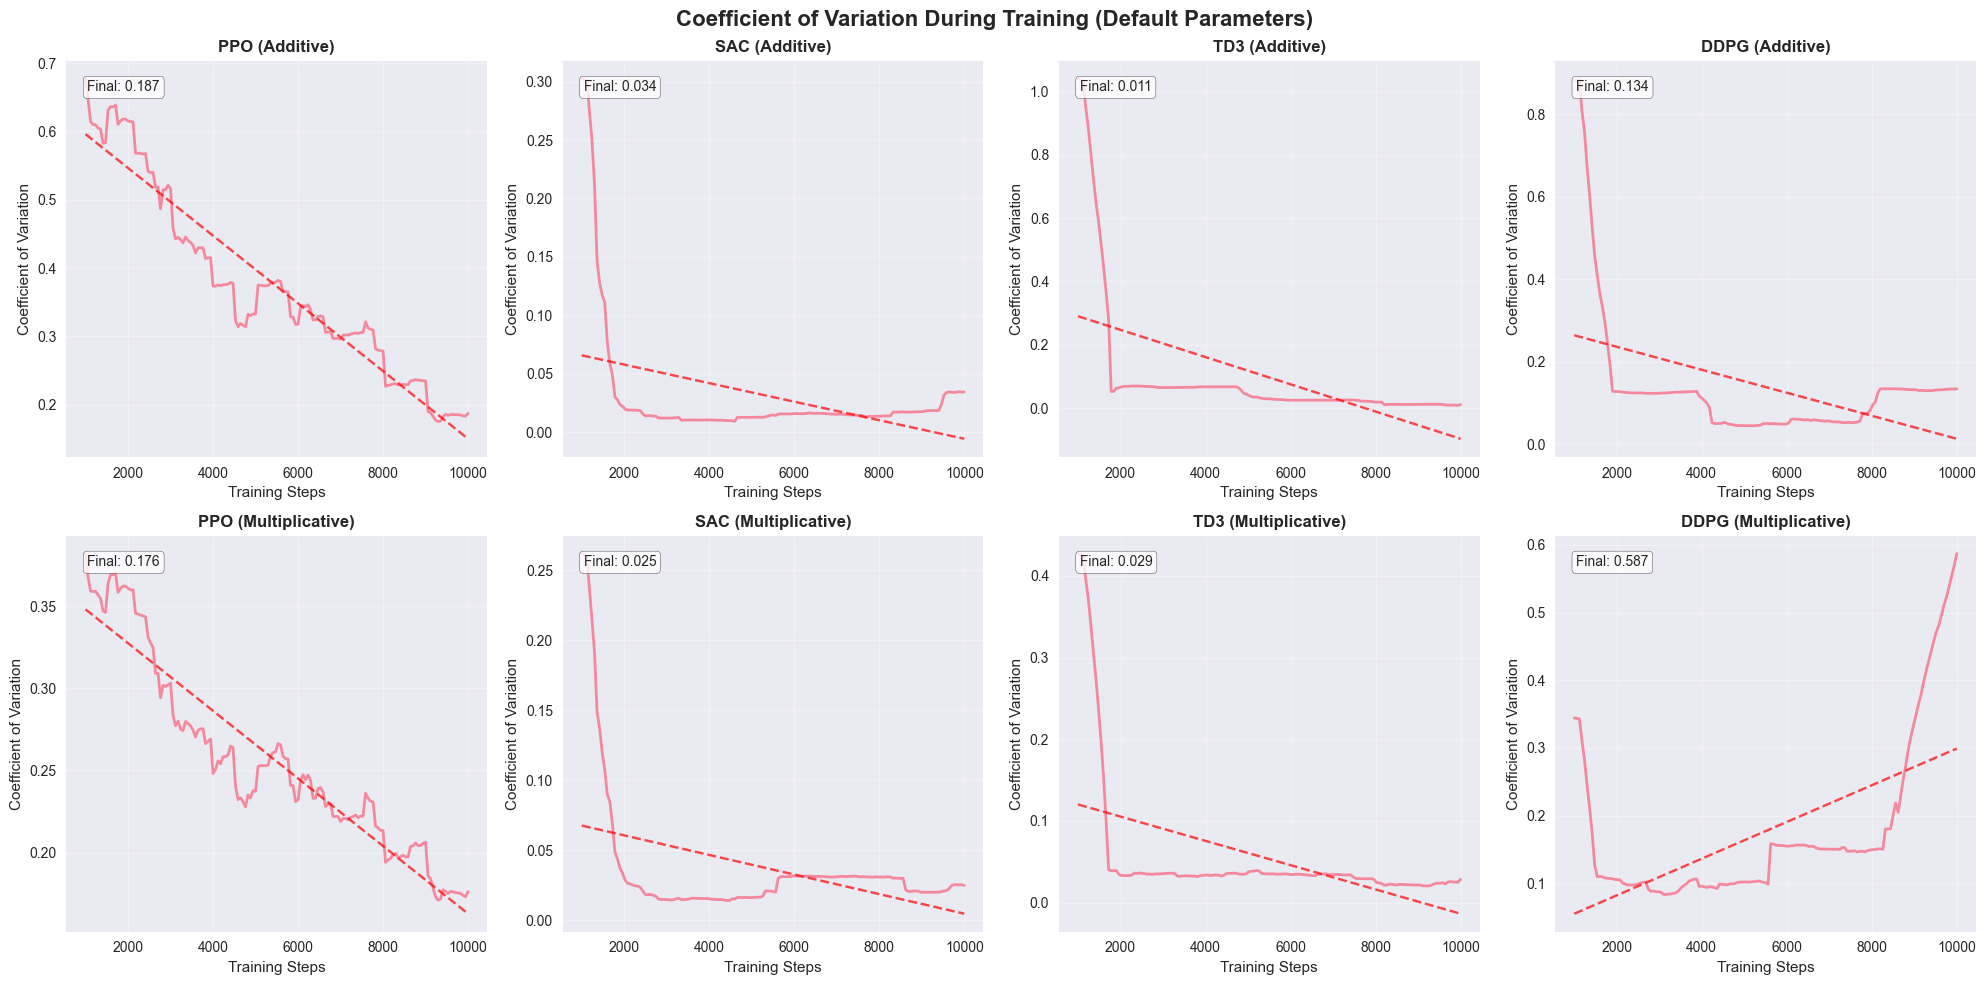

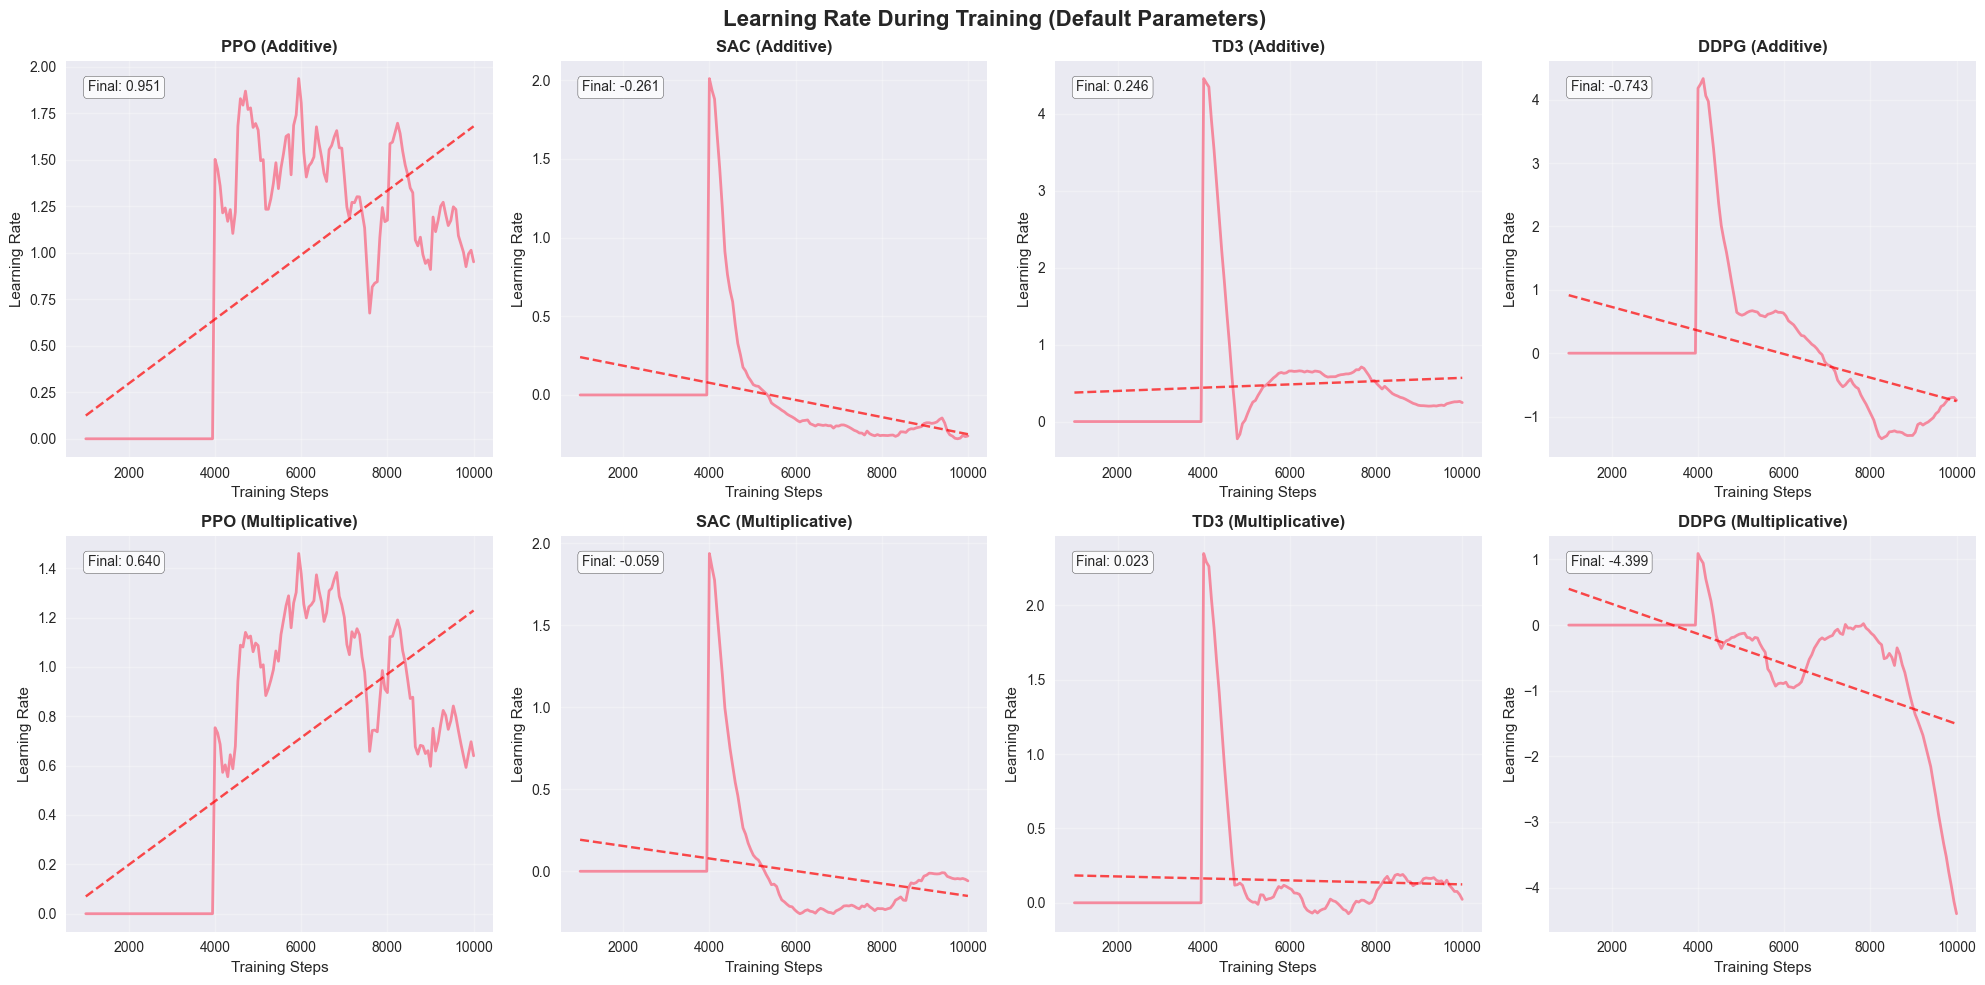

5. Generating training metrics comparison plots...


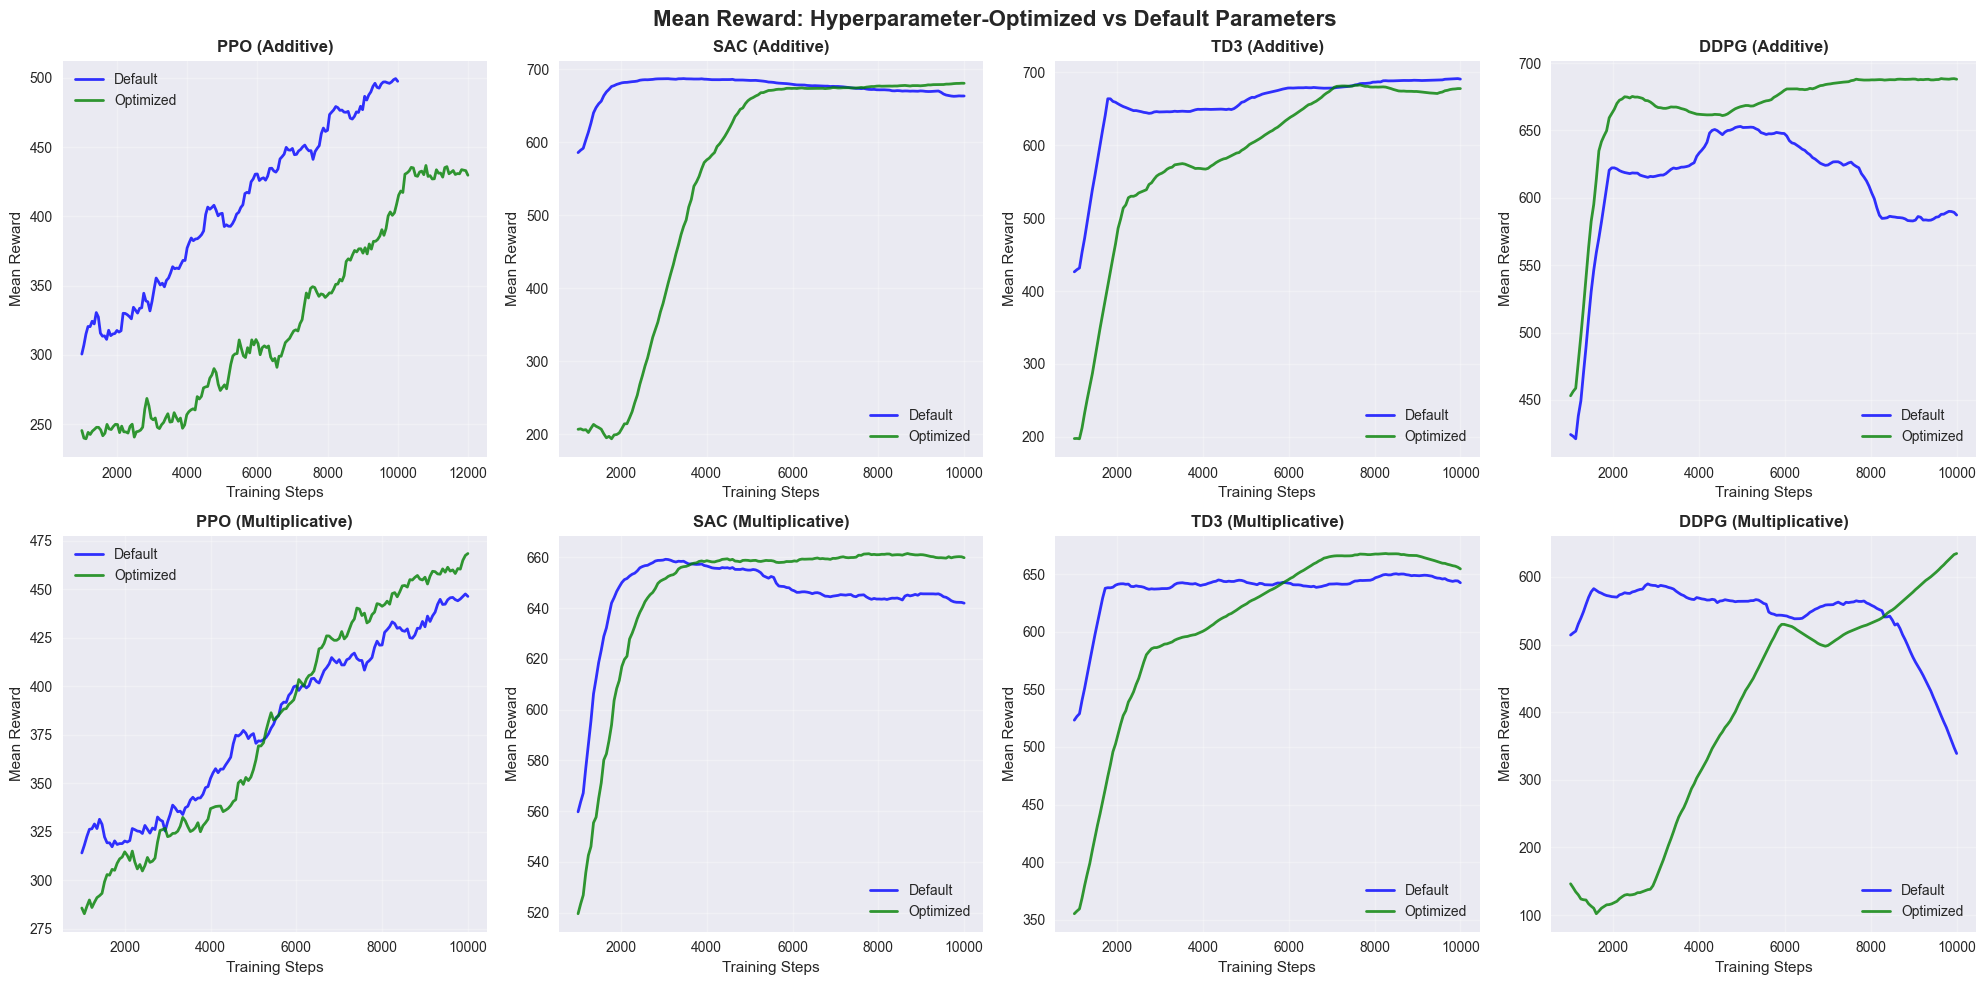

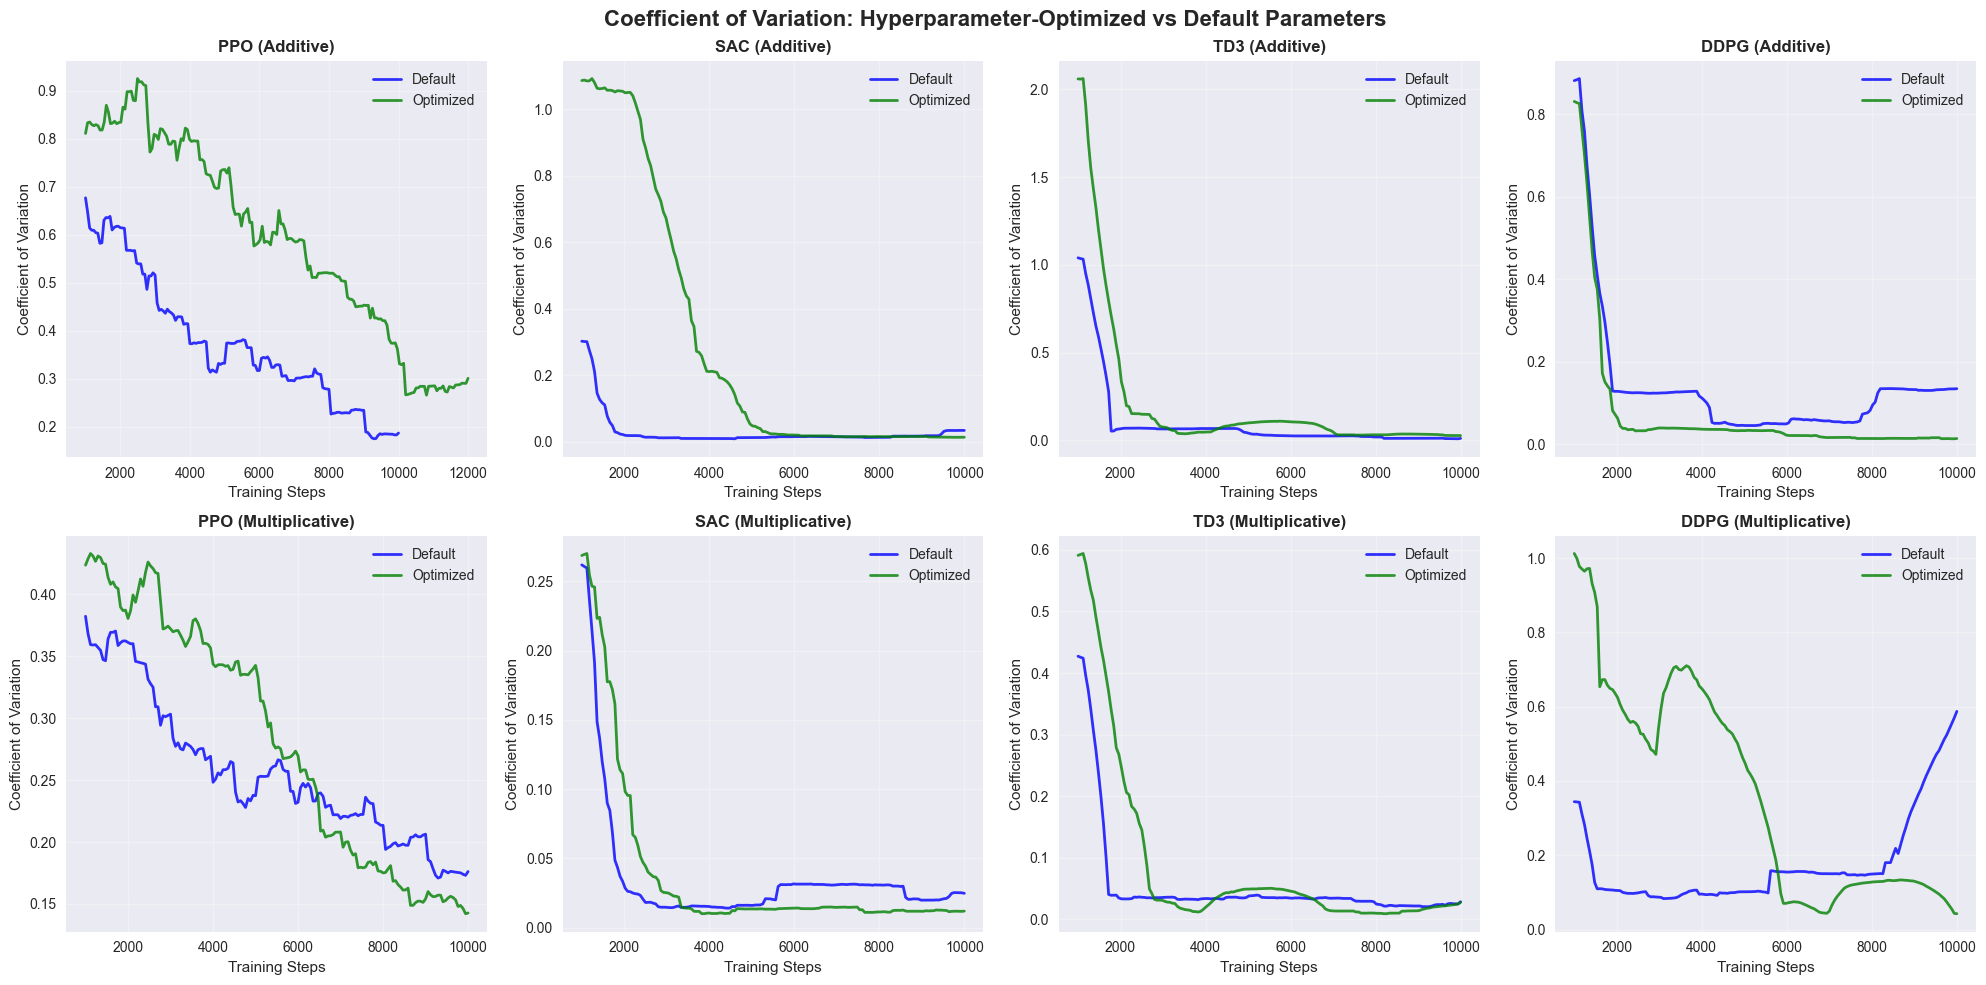

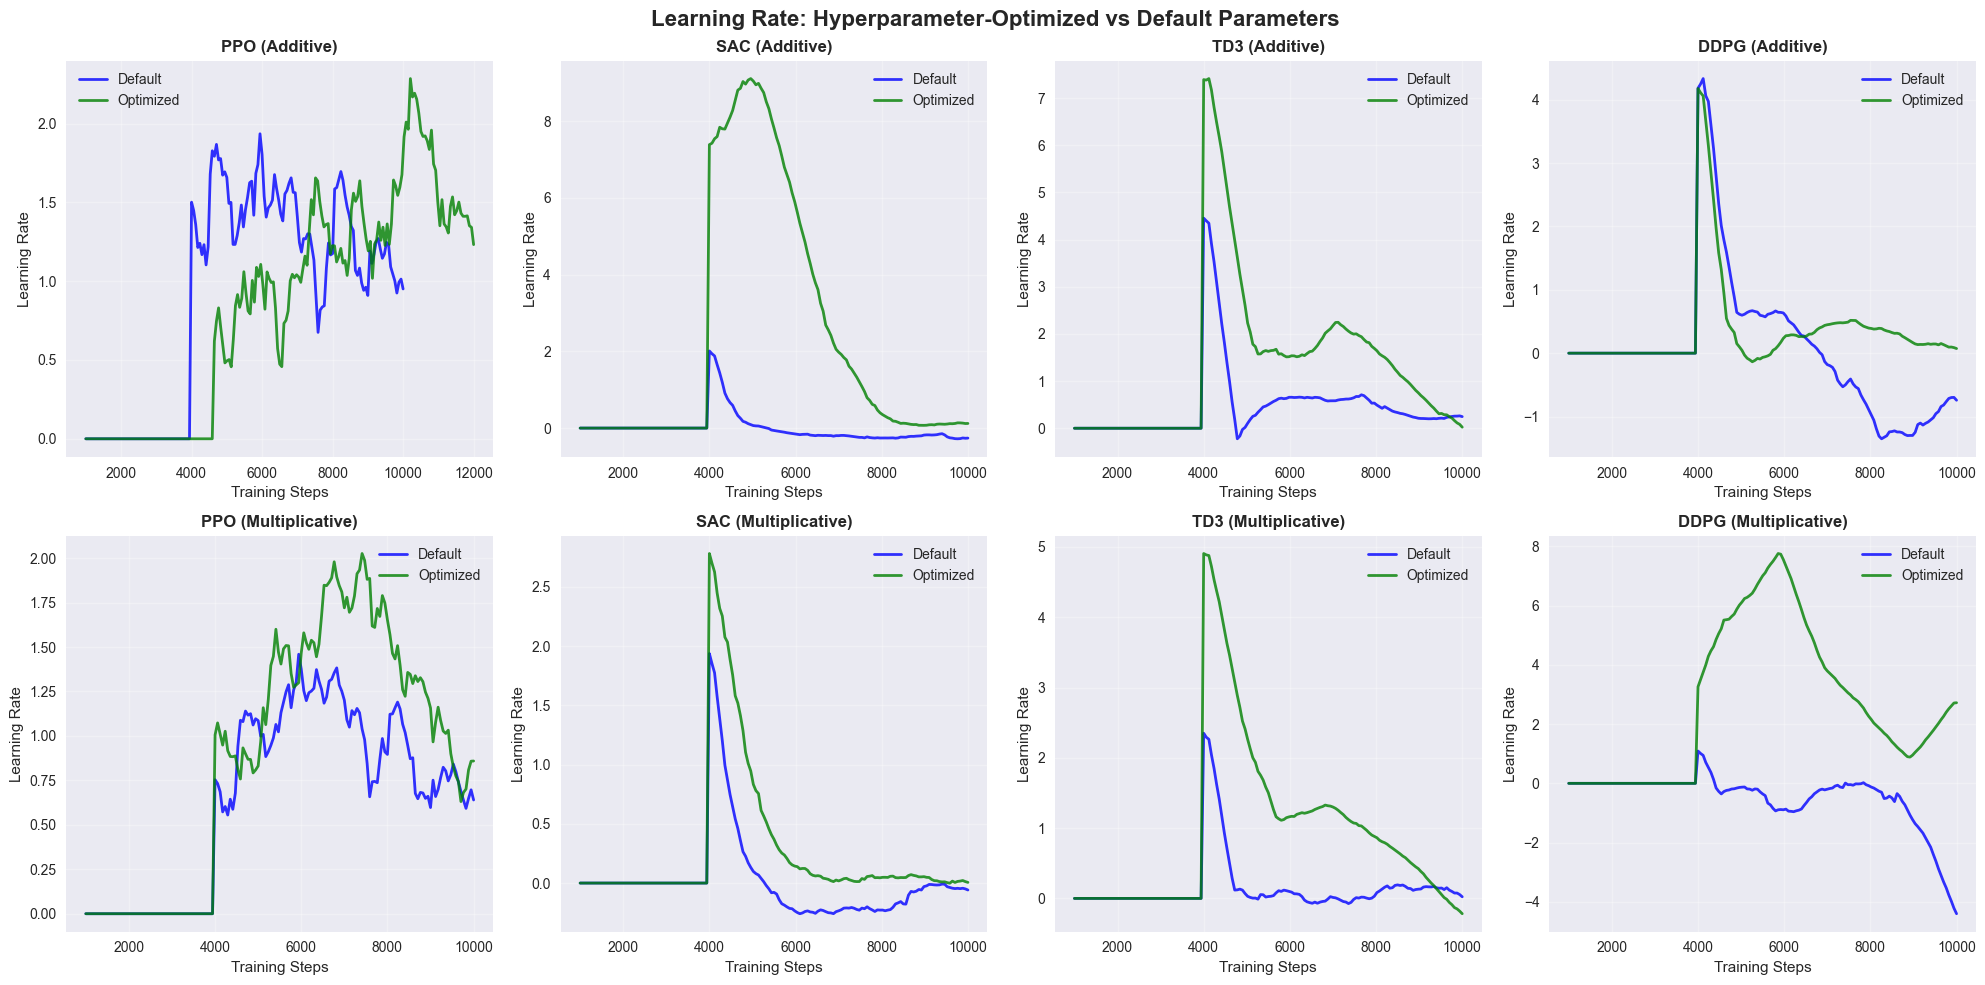


All visualizations generated successfully!


In [8]:
# Generate All Visualizations

print("Generating all required visualizations...")

print("1. Generating episode rewards before training plots...")
plot_episode_rewards_before_training(results)

print("2. Generating before/after training comparison plots...")
plot_episode_rewards_before_after(results)

print("3. Generating hyperparameter-optimized vs default model plots...")
plot_fine_tuned_vs_regular(results)

print("4. Generating training metrics plots for default models...")
plot_training_metrics_non_fine_tuned(results)

print("5. Generating training metrics comparison plots...")
plot_training_metrics_comparison(results)

print("\nAll visualizations generated successfully!")


In [9]:
# Enhanced Results Summary with Hyperparameters


def generate_results_summary(results):
    """Generate comprehensive results summary including hyperparameter optimization results"""

    algorithms = ["PPO", "SAC", "TD3", "DDPG"]
    reward_types = ["additive", "multiplicative"]

    print("\n" + "=" * 80)
    print("COMPREHENSIVE RESULTS SUMMARY WITH HYPERPARAMETER OPTIMIZATION")
    print("=" * 80)

    for reward_type in reward_types:
        print(f"\n{reward_type.upper()} REWARD FUNCTION:")
        print("-" * 50)

        # Create summary table
        summary_data = []
        for algorithm in algorithms:
            before_mean = np.mean(results["before_training"][reward_type][algorithm])
            before_std = np.std(results["before_training"][reward_type][algorithm])
            after_mean = np.mean(results["after_training"][reward_type][algorithm])
            after_std = np.std(results["after_training"][reward_type][algorithm])
            opt_mean = np.mean(results["fine_tuned"][reward_type][algorithm]["rewards"])
            opt_std = np.std(results["fine_tuned"][reward_type][algorithm]["rewards"])

            training_improvement = after_mean - before_mean
            hp_improvement = opt_mean - after_mean
            total_improvement = opt_mean - before_mean

            summary_data.append(
                {
                    "Algorithm": algorithm,
                    "Before Training": f"{before_mean:.2f} ± {before_std:.2f}",
                    "After Training (Default)": f"{after_mean:.2f} ± {after_std:.2f}",
                    "Hyperparameter Optimized": f"{opt_mean:.2f} ± {opt_std:.2f}",
                    "Training Improvement": f"{training_improvement:+.2f}",
                    "HP Optimization Gain": f"{hp_improvement:+.2f}",
                    "Total Improvement": f"{total_improvement:+.2f}",
                }
            )

        # Display table
        df_summary = pd.DataFrame(summary_data)
        print(df_summary.to_string(index=False))

        # Best performing algorithm
        best_algo = max(
            algorithms,
            key=lambda x: np.mean(results["fine_tuned"][reward_type][x]["rewards"]),
        )
        best_score = np.mean(results["fine_tuned"][reward_type][best_algo]["rewards"])
        print(f"\nBest performing algorithm: {best_algo} ({best_score:.2f})")

        # Show best hyperparameters for each algorithm
        print(f"\nOptimal Hyperparameters for {reward_type.capitalize()} Reward:")

        for algorithm in algorithms:
            if (
                "best_hyperparameters" in results
                and reward_type in results["best_hyperparameters"]
            ):
                best_params = results["best_hyperparameters"][reward_type].get(
                    algorithm, {}
                )
                if best_params:
                    print(f"  {algorithm}:")
                    for param, value in best_params.items():
                        if isinstance(value, float):
                            print(f"    {param}: {value:.2e}")
                        else:
                            print(f"    {param}: {value}")

        # Safety analysis
        print(f"\nSafety Analysis for {reward_type.capitalize()} Reward:")

        for algorithm in algorithms:
            opt_rewards = results["fine_tuned"][reward_type][algorithm]["rewards"]
            safe_episodes = np.sum(
                np.array(opt_rewards) > -5
            )  # Threshold for "safe" episodes
            safety_rate = safe_episodes / len(opt_rewards) * 100
            print(f"  {algorithm}: {safety_rate:.1f}% safe episodes")


# Generate the enhanced summary
generate_results_summary(results)

# Additional analysis comparing hyperparameter optimization effectiveness
print("\n" + "=" * 80)
print("HYPERPARAMETER OPTIMIZATION EFFECTIVENESS")
print("=" * 80)

for reward_type in ["additive", "multiplicative"]:
    print(f"\n{reward_type.upper()} Reward - HP Optimization Gains:")

    for algorithm in ["PPO", "SAC", "TD3", "DDPG"]:
        default_score = np.mean(results["after_training"][reward_type][algorithm])
        optimized_score = np.mean(
            results["fine_tuned"][reward_type][algorithm]["rewards"]
        )
        gain = optimized_score - default_score
        gain_percent = (gain / abs(default_score)) * 100 if default_score != 0 else 0
        print(f"  {algorithm}: {gain:+.2f} ({gain_percent:+.1f}%)")

print("\nEnhanced analysis complete!")


COMPREHENSIVE RESULTS SUMMARY WITH HYPERPARAMETER OPTIMIZATION

ADDITIVE REWARD FUNCTION:
--------------------------------------------------
Algorithm Before Training After Training (Default) Hyperparameter Optimized Training Improvement HP Optimization Gain Total Improvement
      PPO 259.37 ± 149.22            689.70 ± 4.49            676.13 ± 8.49              +430.33               -13.57           +416.76
      SAC 413.86 ± 122.47            675.76 ± 6.85            691.82 ± 5.31              +261.90               +16.06           +277.96
      TD3 -423.56 ± 55.18            685.92 ± 7.31            689.50 ± 6.50             +1109.48                +3.58          +1113.06
     DDPG -423.56 ± 55.18            481.60 ± 7.74            651.34 ± 5.76              +905.16              +169.75          +1074.91

Best performing algorithm: SAC (691.82)

Optimal Hyperparameters for Additive Reward:
  PPO:
    learning_rate: 7.59e-05
    n_steps: 4096
    batch_size: 64
    n_epochs: 18
  